# Generative Adversarial Networks and MNIST

Generative adversarial networks are actually a combination of two neural networks called the Generator and Discriminator:

![GAN Diagram](assets/GAN_diagram.jpg)

The input for the discriminator is always either a sample from the training data, or a sample created by the generator. Using this setup, the discriminator is typically a binary classifier: Its job is to classify samples as real examples (i.e. samples from the training set) or fake examples (i.e. examples created by the generator). The generator's job, then, is to produce data that realistically mimics samples from the training set. In order to force the generator to create many different samples we provide random noise as input to the generator. 

In this notebook, the real samples will be handwritten digits from the MNIST dataset, and we'll train a generator that  creates (somewhat) realistic digits.

## Preparing The Data

Like every other situation we've encoutered so far, we're going to perform some preprocessing on the image data from MNIST to maximize performance and ensure our Keras model can handle the shapes properly.

In [1]:
from keras.datasets.mnist import load_data
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Flatten, Dense, Reshape
from keras.optimizers import Adam

import numpy as np

from matplotlib import pyplot as plt

# This is a bit different than we're used to for other 
# MNIST networks we've built. Note that we don't care
# at all about the "class" — we are NOT trying to identify
# digits. We're only trying to make passable fakes.
(real_train_images, _), (real_test_images, _) = load_data()

Using TensorFlow backend.


In [2]:
# Some people suggest swapping the label value from
# what is usual, i.e. using 1 for fake and 0 for real
# in order to improve the training process. These 
# allow you to play around with that.
REAL_LABEL_VALUE = 0
FAKE_LABEL_VALUE = 1

In [3]:
# We have to do some slight processing of the MNIST input images.
# Specifically, keras expects 3 dimentional input, 
# height, width, and color channels.

# since we have black/white images we just use np.expand_dims
# to go from (28, 28) => (28, 28, 1). This should feel familiar,
# if you've used CNNs in keras at all.

# We're also going to normalize from the 0-255 domain to 0.0-1.0
def prepare_real_samples(samples):
    prepared_samples = np.expand_dims(samples, axis=-1)
    prepared_samples = prepared_samples.astype('float32')
    prepared_samples = prepared_samples / 255.0
    
    return prepared_samples


# Because the network is trained on the binary question
# "real" or "fake" this helper function selects a number 
# of samples from a set of samples that has already been
# "prepared" by the previous function. 

# We select a random sample, and provide the label
# for each of the selected samples.

# Crucially, we ASSUME that "samples" is a set of real
# examples prepared with prepare_real_samples. It is possible
# to pass fake/generated samples to this function, but that
# would be very bad for our GAN. 
def generate_real_batch(samples, n_samples):
    indices = np.random.randint(0, samples.shape[0], n_samples)
    batch_images = samples[indices]
    batch_labels = np.full((n_samples, 1), REAL_LABEL_VALUE)

    return batch_images, batch_labels


# We're going to give our discriminator a head start
# by allowing it to train, on its own, against totally
# random noise. 

# Later, we'll add a generator network and train
# the discriniator against the output of that network.
# This function generates a number of images.
def generate_random_fake_batch(n_samples, shape=(28,28,1)):
    # Random numbers 0.0-1.0 from a uniform distribution in a flat numpy Array
    batch = np.random.rand(shape[0] * shape[1] * shape[2] * n_samples)
    
    # Unflatten the list according to the provided shape
    batch = batch.reshape((n_samples, shape[0], shape[1], shape[2]))

    labels = np.full((n_samples, 1), FAKE_LABEL_VALUE)
    return batch, labels

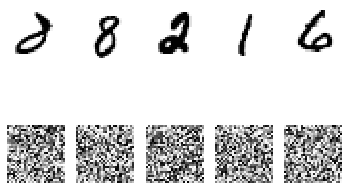

In [4]:
# Prepare the dataset
prepared_real_images = prepare_real_samples(real_train_images)

# Lets quickly visualize our "real" data vs our "fake" data.
real_x, _ = generate_real_batch(prepared_real_images, 5)
fake_x, _ = generate_random_fake_batch(5)

all_x = np.concatenate((real_x, fake_x))

for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.axis('off')
    
    # imshow only works for (h, w) or (h, w, color) IF color == 3 or 4
    # we have color == 1, so we use this annoying hack to slice off
    # the last dimension. (by taking the value at the 0th position,
    # which is the only position available since we're (28,28,1))
    plt.imshow(all_x[i, :, :, 0], cmap='Greys')


## The Discriminator

The Discriminator is a CNN, a binary classifier, and in our case relatively simple. Before we move on to building the generator we're going to do a "gut check" on our discriminator architecture by checking that it can tell the difference between randomly generated noise, and digits from the MNIST dataset. 

In [5]:
# The discriminator accepts an image as input. The image is
# either a real example, or a generated one. The discriminator
# makes a binary decision about which it is, real or false.

# The default input shape is selected to match the MNIST dataset
# and could be changed to support other datasets.

# This simple network will be satisfactory for the simple MNIST dataset.
# Leaky, 2x2 striding, dropout, and batch normalization are all 
# suggested best practices for GAN at the time of this writting. 
# See "Resources for Further Exploration" for the reasoning.
def create_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # Note the quite small learning rate.
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [6]:
# Okay, lets put all that together by training our discriminator
# on real MNIST digits for the "real" and random noise for the "fake"

INPUT_SHAPE = (28, 28, 1) # MNIST specific
BATCH_SIZE = 256          # How many of EACH real/fake to train during each round?
BATCH_N = 5               # How many rounds? 

# Get a copy of the discriminator
discriminator_network = create_discriminator(INPUT_SHAPE)

# Each of these for loop iterations is analogous to a single epoch
# but we are getting a random sample of real images, and brand new
# noise vectors each epoch. Additionally, we're not seeing EVERY real
# sample on each epoch.
for current_round in range(BATCH_N):
    real_x, real_y = generate_real_batch(prepared_real_images, BATCH_SIZE)
    fake_x, fake_y = generate_random_fake_batch(BATCH_SIZE, INPUT_SHAPE)
    
    full_x = np.concatenate((real_x, fake_x))
    full_y = np.concatenate((real_y, fake_y))
    
    print(f"Round number {current_round}")
    discriminator_network.fit(full_x, full_y, batch_size=BATCH_SIZE, epochs=1, verbose=True)


Round number 0
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 0.9956 - accuracy: 0.4199
Round number 1
Epoch 1/1
512/512 [==============================] - 0s 543us/step - loss: 0.7428 - accuracy: 0.5801
Round number 2
Epoch 1/1
512/512 [==============================] - 0s 535us/step - loss: 0.5010 - accuracy: 0.7480
Round number 3
Epoch 1/1
512/512 [==============================] - 0s 518us/step - loss: 0.4027 - accuracy: 0.8262
Round number 4
Epoch 1/1
512/512 [==============================] - 0s 540us/step - loss: 0.2857 - accuracy: 0.9121


After 5*512 = 2560 samples, our discriminator can easily distinguish between random noise and real digits. If our discriminator could not do this relatively easily / quickly, we would want to revisit our architecture until it could. 

## The Generator

In [7]:
# Generators need to recieve some random noise as the "seed" of their
# output. The amount of unique noise available to the network limits 
# the number of unique outputs the generator can create.

# Furthermore, we must transform this noise into a shape
# that our CNN can work with.

# Emperically, reseachers have had success with the strategy below
# for selecting the magnitude of this noise. Other tactics can also
# work. See the Resources for Further Exploration for more. 

# Our input shape is based on an arbitrary amount of noise.
# we'll use 100 below, but you can experiment with other values
# that also work well. 

# Our generator starts with a dense layer that should have enough nodes
# to represent several examples of a low-resolution version of our image. 
# Then, we iteratively upsample using Conv2DTranspose until
# we have images that are the right shape: (28, 28).
def create_generator(noise_dim, dense_layer_nodes):
    model = Sequential()

    model.add(Dense(dense_layer_nodes, input_dim=noise_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Reshape((7, 7, 128)))

    # Upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    # Upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    
    # Finally layer only has one filter and a wide convolution kernal.
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model


# We also need to generate a noise vector that matches 
# the noise shape we choose.
def generate_noise_vector(noise_dim, n_samples):
    noise_vector = np.random.randn(noise_dim * n_samples)
    noise_vector = noise_vector.reshape(n_samples, noise_dim)

    return noise_vector


# Finally, we need to be able to use the generator to 
# make a fake digit! Again, generate a batch and lables (all 0)
def generate_fake_batch(generator, noise_dim, n_samples):
    noise_vector = generate_noise_vector(noise_dim, n_samples)
    batch = generator.predict(noise_vector)
    labels = np.full((n_samples, 1), FAKE_LABEL_VALUE)

    return batch, labels

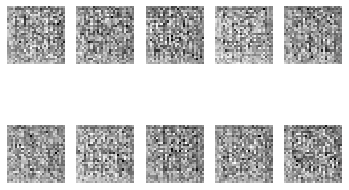

In [8]:
# Lets visualize some examples of the untrained fake
# images... they will probably still just look like 
# noise, but we can see how these functions work.

# 100 is arbitrary, but a commonly used value.
NOISE_DIM = 100

# This number should be a large enough space to represent
# "a handful of low resolution examples" of the images we're
# trying to generate. In our case, 7*7 is the "low resolution"
# (downsampled by a factor of 4, from 28 * 28 -> 7 * 7) and 128
# is "a handful".
DENSE_LAYER_SIZE = 128 * 7 * 7

# Increasing both or either the NOISE_DIM or DENSE_LAYER_SIZE will 
# increase the number of unique representations that our generator
# will ultimately generate. It will also increase the number of 
# parameters in the network of course, so it will increase training time.

generator = create_generator(NOISE_DIM, DENSE_LAYER_SIZE)

fake_images, _ = generate_fake_batch(generator, NOISE_DIM, 10)

for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.axis('off')
    
    # imshow only works for (h, w) or (h, w, color) IF color == 3 or 4
    # we have color == 1, so we use this annoying hack to slice off
    # the last dimension. (by taking the value at the 0th position,
    # which is the only position available since we're (28,28,1))
    plt.imshow(fake_images[i, :, :, 0], cmap='Greys')

Wonderfully noisy. Now, how do we get this thing to produce fake digits?

## The "Generative Adversarial Network" and Training

As we mentioned, the GAN is actually a composition of both the generator and the discriminator, arranged sequentially. We need the output from the discriminator in order to train the GAN — the generator's performance is a function of its ability to trick the discrimintaor. Similarly, to train the discriminator, we need to send it samples from the generator **as well as** real samples from the training set.

Training a GAN is typically broken into three separate training processes:

1. Train the discriminator on a batch of real samples.
2. Train the discriminator on a batch of fake (generated) samples. 
3. Train the generator by freezing the discriminator and inverting the labels on generated images.

The discriminator and generator are NOT trained at the same time, instead they are trained iteratively in small batches. When the discriminator is learning, the generator's weights are not modified. When the generator is learning, the discriminators weigths are not modified. 

Lets see how this works:

In [14]:
def create_gan(generator, discriminator):
    # The output of the generator is the input to the discriminator.
    # The output of the discriminator matches our lables (0, 1) for (fake, real)
    model = Sequential()
    model.add(generator)

    # When the GAN trains, it only trains the generator.
    # the discriminator has to be trained separately. 
    # This honestly seems like the wrong way to do this...
    # But apparently it's totally legit: https://github.com/keras-team/keras/issues/8585
    discriminator.trainable = False
    model.add(discriminator)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model


# A lot of work has gone into figuring out strategies
# for training GANs, and some of the best practices include:

# Freezing the discriminator while we train the generator, this
# creates a stable target for the generator to work against. 

# Periodically updating the discriminator BY ITSELF with batches
# of fake images from the generator and real images from the dataset. 

# Inverting the label of "fake" images during generator training. 
#   In order to fool the discriminator, we invert the labels.
#   The idea is that when the discrimiator is doing a GOOD job 
#   (i.e. low loss / error) we need to tell the generator that its
#   doing a BAD job. A very quick way to achieve this is to flip
#   labels when training the generator. 
def train_gan(gan, generator, discriminator, noise_dim, batches, batch_size, verbose=True):
    print("Training... \nDiscriminator Real Acc, Discriminator Fake Acc, Generator Acc")
    for i in range(batches):
        real_batch_images, real_batch_labels = generate_real_batch(prepared_real_images, batch_size // 2)
        fake_batch_images, fake_batch_labels = generate_fake_batch(generator, noise_dim, batch_size // 2)


        # Training a batch of real, then a batch of fake, rather than a shuffled mix
        # could impact training, but it gives us more granular information about the
        # discriminator's performance. 
        _, discriminator_real_acc = discriminator.train_on_batch(real_batch_images, real_batch_labels)
        _, discriminator_fake_acc = discriminator.train_on_batch(fake_batch_images, fake_batch_labels)
        
        
        # Make some noise for the full model to train on
        gan_input_vector = generate_noise_vector(noise_dim, batch_size)

        # In order to fool the discriminator, we invert the labels.
        # The idea is that when the discrimiator is doing a GOOD job 
        # (i.e. low loss / error) we need to tell the generator that its
        # doing a BAD job. A very quick way to achieve this is to flip
        # labels when training the generator. 
        gan_labels = np.full((batch_size, 1), REAL_LABEL_VALUE)
        _, gan_acc = gan.train_on_batch(gan_input_vector, gan_labels)
        
        if verbose: print(f"{i} / {batches}: {discriminator_real_acc}, {discriminator_fake_acc}, {gan_acc}")

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc


/Users/tylerbettilyon/.local/share/virtualenvs/deep-learning-intro-1Adgpw9A/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/tylerbettilyon/.local/share/virtualenvs/deep-learning-intro-1Adgpw9A/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 / 100: 0.3359375, 0.609375, 0.35546875


/Users/tylerbettilyon/.local/share/virtualenvs/deep-learning-intro-1Adgpw9A/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 / 100: 0.4921875, 0.734375, 0.453125
2 / 100: 0.5546875, 0.828125, 0.4375
3 / 100: 0.734375, 0.9296875, 0.59765625
4 / 100: 0.796875, 0.9609375, 0.64453125
5 / 100: 0.8359375, 0.9609375, 0.71875
6 / 100: 0.875, 0.96875, 0.765625
7 / 100: 0.953125, 0.9921875, 0.828125
8 / 100: 0.9453125, 0.9921875, 0.86328125
9 / 100: 0.96875, 0.9921875, 0.84375
10 / 100: 0.984375, 1.0, 0.91796875
11 / 100: 0.984375, 1.0, 0.96875
12 / 100: 0.984375, 1.0, 0.95703125
13 / 100: 0.9921875, 1.0, 0.96484375
14 / 100: 1.0, 1.0, 0.9765625
15 / 100: 0.9921875, 1.0, 0.99609375
16 / 100: 1.0, 1.0, 0.984375
17 / 100: 0.9921875, 1.0, 0.98828125
18 / 100: 1.0, 1.0, 0.9921875
19 / 100: 0.984375, 1.0, 0.9921875
20 / 100: 0.9921875, 1.0, 1.0
21 / 100: 1.0, 1.0, 0.98828125
22 / 100: 1.0, 1.0, 0.984375
23 / 100: 1.0, 1.0, 1.0
24 / 100: 1.0, 1.0, 1.0
25 / 100: 1.0, 1.0, 1.0
26 / 100: 1.0, 1.0, 1.0
27 / 100: 1.0, 1.0, 1.0
28 / 100: 0.9921875, 1.0, 1.0
29 / 100: 0.9921875, 1.0, 1.0
30 / 100: 1.0, 1.0, 1.0
31 / 100: 1.0, 1.

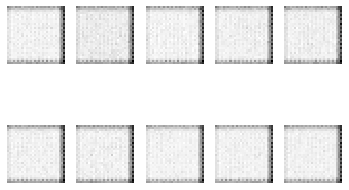

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 1.0
1 / 100: 1.0, 1.0, 1.0
2 / 100: 1.0, 1.0, 1.0
3 / 100: 1.0, 1.0, 1.0
4 / 100: 1.0, 1.0, 1.0
5 / 100: 1.0, 1.0, 1.0
6 / 100: 1.0, 1.0, 1.0
7 / 100: 1.0, 1.0, 1.0
8 / 100: 1.0, 1.0, 1.0
9 / 100: 1.0, 1.0, 1.0
10 / 100: 1.0, 1.0, 1.0
11 / 100: 1.0, 1.0, 1.0
12 / 100: 1.0, 1.0, 1.0
13 / 100: 1.0, 1.0, 1.0
14 / 100: 1.0, 1.0, 1.0
15 / 100: 1.0, 1.0, 1.0
16 / 100: 1.0, 1.0, 1.0
17 / 100: 1.0, 1.0, 1.0
18 / 100: 1.0, 1.0, 1.0
19 / 100: 1.0, 1.0, 1.0
20 / 100: 1.0, 1.0, 1.0
21 / 100: 1.0, 1.0, 1.0
22 / 100: 1.0, 1.0, 1.0
23 / 100: 1.0, 1.0, 1.0
24 / 100: 1.0, 1.0, 1.0
25 / 100: 1.0, 1.0, 1.0
26 / 100: 1.0, 1.0, 1.0
27 / 100: 1.0, 1.0, 1.0
28 / 100: 1.0, 1.0, 1.0
29 / 100: 1.0, 1.0, 1.0
30 / 100: 1.0, 1.0, 1.0
31 / 100: 1.0, 1.0, 1.0
32 / 100: 1.0, 1.0, 1.0
33 / 100: 1.0, 1.0, 1.0
34 / 100: 1.0, 1.0, 1.0
35 / 100: 1.0, 1.0, 1.0
36 / 100: 1.0, 1.0, 1.0
37 / 100: 1.0, 1.0, 1.0
38 / 100: 1.0, 1.0, 1.0

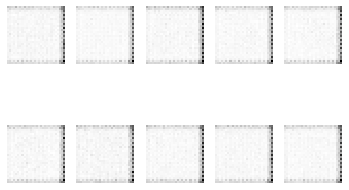

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 1.0
1 / 100: 1.0, 1.0, 1.0
2 / 100: 1.0, 1.0, 1.0
3 / 100: 1.0, 1.0, 1.0
4 / 100: 1.0, 1.0, 1.0
5 / 100: 1.0, 1.0, 1.0
6 / 100: 1.0, 1.0, 1.0
7 / 100: 1.0, 1.0, 1.0
8 / 100: 1.0, 1.0, 1.0
9 / 100: 1.0, 1.0, 1.0
10 / 100: 1.0, 1.0, 1.0
11 / 100: 1.0, 1.0, 1.0
12 / 100: 1.0, 1.0, 1.0
13 / 100: 1.0, 1.0, 1.0
14 / 100: 1.0, 1.0, 1.0
15 / 100: 1.0, 1.0, 1.0
16 / 100: 1.0, 1.0, 1.0
17 / 100: 1.0, 1.0, 1.0
18 / 100: 1.0, 1.0, 1.0
19 / 100: 1.0, 1.0, 1.0
20 / 100: 1.0, 1.0, 1.0
21 / 100: 1.0, 1.0, 1.0
22 / 100: 1.0, 1.0, 1.0
23 / 100: 1.0, 1.0, 1.0
24 / 100: 1.0, 1.0, 1.0
25 / 100: 1.0, 1.0, 1.0
26 / 100: 1.0, 1.0, 1.0
27 / 100: 1.0, 1.0, 1.0
28 / 100: 1.0, 1.0, 1.0
29 / 100: 1.0, 1.0, 1.0
30 / 100: 1.0, 1.0, 1.0
31 / 100: 1.0, 1.0, 1.0
32 / 100: 1.0, 1.0, 1.0
33 / 100: 1.0, 1.0, 1.0
34 / 100: 1.0, 1.0, 1.0
35 / 100: 1.0, 1.0, 1.0
36 / 100: 1.0, 1.0, 1.0
37 / 100: 1.0, 1.0, 1.0
38 / 100: 1.0, 1.0, 1.0

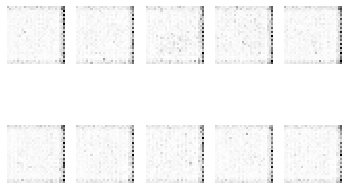

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 1.0
1 / 100: 1.0, 1.0, 1.0
2 / 100: 1.0, 1.0, 1.0
3 / 100: 1.0, 1.0, 1.0
4 / 100: 1.0, 1.0, 1.0
5 / 100: 1.0, 1.0, 1.0
6 / 100: 1.0, 1.0, 1.0
7 / 100: 1.0, 1.0, 1.0
8 / 100: 1.0, 1.0, 1.0
9 / 100: 1.0, 1.0, 1.0
10 / 100: 1.0, 1.0, 1.0
11 / 100: 1.0, 1.0, 1.0
12 / 100: 1.0, 1.0, 1.0
13 / 100: 1.0, 1.0, 1.0
14 / 100: 1.0, 1.0, 1.0
15 / 100: 1.0, 1.0, 1.0
16 / 100: 1.0, 1.0, 1.0
17 / 100: 1.0, 1.0, 1.0
18 / 100: 1.0, 1.0, 1.0
19 / 100: 1.0, 1.0, 1.0
20 / 100: 1.0, 1.0, 1.0
21 / 100: 1.0, 1.0, 1.0
22 / 100: 1.0, 1.0, 1.0
23 / 100: 1.0, 1.0, 1.0
24 / 100: 1.0, 1.0, 1.0
25 / 100: 1.0, 1.0, 1.0
26 / 100: 1.0, 1.0, 1.0
27 / 100: 1.0, 1.0, 1.0
28 / 100: 1.0, 1.0, 1.0
29 / 100: 1.0, 1.0, 1.0
30 / 100: 1.0, 1.0, 1.0
31 / 100: 1.0, 1.0, 1.0
32 / 100: 1.0, 1.0, 1.0
33 / 100: 1.0, 1.0, 1.0
34 / 100: 1.0, 1.0, 1.0
35 / 100: 1.0, 1.0, 1.0
36 / 100: 1.0, 1.0, 1.0
37 / 100: 1.0, 1.0, 1.0
38 / 100: 1.0, 1.0, 1.0

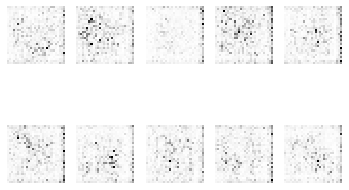

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 0.9921875, 1.0
1 / 100: 1.0, 1.0, 1.0
2 / 100: 1.0, 1.0, 1.0
3 / 100: 1.0, 1.0, 1.0
4 / 100: 1.0, 1.0, 1.0
5 / 100: 1.0, 1.0, 1.0
6 / 100: 1.0, 1.0, 1.0
7 / 100: 1.0, 1.0, 1.0
8 / 100: 1.0, 0.9921875, 1.0
9 / 100: 1.0, 1.0, 1.0
10 / 100: 1.0, 1.0, 1.0
11 / 100: 1.0, 0.9921875, 1.0
12 / 100: 1.0, 0.984375, 0.99609375
13 / 100: 1.0, 1.0, 1.0
14 / 100: 1.0, 1.0, 1.0
15 / 100: 1.0, 0.9921875, 1.0
16 / 100: 1.0, 0.96875, 1.0
17 / 100: 1.0, 1.0, 1.0
18 / 100: 1.0, 0.9609375, 1.0
19 / 100: 1.0, 0.984375, 1.0
20 / 100: 0.96875, 0.9453125, 1.0
21 / 100: 1.0, 0.9921875, 1.0
22 / 100: 0.9921875, 0.9765625, 1.0
23 / 100: 1.0, 0.96875, 1.0
24 / 100: 0.984375, 0.9921875, 1.0
25 / 100: 0.9921875, 0.984375, 1.0
26 / 100: 0.9921875, 1.0, 1.0
27 / 100: 1.0, 0.9921875, 1.0
28 / 100: 0.984375, 0.9921875, 1.0
29 / 100: 1.0, 0.984375, 1.0
30 / 100: 1.0, 0.9921875, 1.0
31 / 100: 0.984375, 1.0, 1.0
32 / 100: 0.9921875, 1.

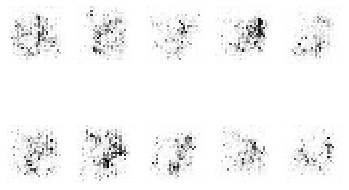

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 1.0
1 / 100: 1.0, 1.0, 1.0
2 / 100: 1.0, 1.0, 1.0
3 / 100: 1.0, 1.0, 1.0
4 / 100: 1.0, 1.0, 1.0
5 / 100: 1.0, 1.0, 1.0
6 / 100: 1.0, 0.9921875, 1.0
7 / 100: 0.9921875, 1.0, 1.0
8 / 100: 1.0, 0.9921875, 1.0
9 / 100: 1.0, 1.0, 1.0
10 / 100: 1.0, 1.0, 1.0
11 / 100: 1.0, 1.0, 1.0
12 / 100: 1.0, 1.0, 1.0
13 / 100: 1.0, 1.0, 1.0
14 / 100: 1.0, 1.0, 1.0
15 / 100: 1.0, 0.9921875, 1.0
16 / 100: 1.0, 1.0, 1.0
17 / 100: 1.0, 1.0, 1.0
18 / 100: 1.0, 0.9921875, 1.0
19 / 100: 1.0, 1.0, 1.0
20 / 100: 1.0, 1.0, 1.0
21 / 100: 1.0, 1.0, 1.0
22 / 100: 1.0, 0.9921875, 1.0
23 / 100: 1.0, 1.0, 1.0
24 / 100: 1.0, 1.0, 1.0
25 / 100: 1.0, 1.0, 1.0
26 / 100: 1.0, 0.9921875, 1.0
27 / 100: 1.0, 1.0, 1.0
28 / 100: 1.0, 1.0, 1.0
29 / 100: 1.0, 0.9921875, 1.0
30 / 100: 1.0, 1.0, 1.0
31 / 100: 1.0, 1.0, 1.0
32 / 100: 1.0, 0.9921875, 1.0
33 / 100: 0.9921875, 0.9921875, 1.0
34 / 100: 1.0, 1.0, 1.0
35 / 100: 1.0, 0.9921875, 1.0

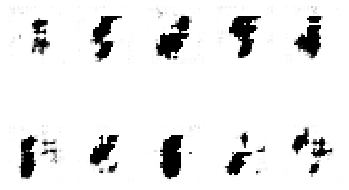

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5625, 0.5234375, 0.24609375
1 / 100: 0.4921875, 0.484375, 0.32421875
2 / 100: 0.5078125, 0.6328125, 0.27734375
3 / 100: 0.515625, 0.5546875, 0.32421875
4 / 100: 0.6015625, 0.453125, 0.359375
5 / 100: 0.609375, 0.515625, 0.27734375
6 / 100: 0.40625, 0.4375, 0.2890625
7 / 100: 0.578125, 0.671875, 0.36328125
8 / 100: 0.5625, 0.53125, 0.45703125
9 / 100: 0.734375, 0.4375, 0.40234375
10 / 100: 0.4921875, 0.46875, 0.5
11 / 100: 0.59375, 0.4375, 0.46484375
12 / 100: 0.5, 0.390625, 0.453125
13 / 100: 0.484375, 0.5078125, 0.5234375
14 / 100: 0.5, 0.3203125, 0.58203125
15 / 100: 0.609375, 0.375, 0.51953125
16 / 100: 0.578125, 0.453125, 0.42578125
17 / 100: 0.53125, 0.5703125, 0.52734375
18 / 100: 0.6484375, 0.3984375, 0.4921875
19 / 100: 0.609375, 0.4921875, 0.44140625
20 / 100: 0.5, 0.4609375, 0.40625
21 / 100: 0.6015625, 0.421875, 0.48046875
22 / 100: 0.5, 0.3984375, 0.44140625
23 / 100: 0.46875, 0.3125, 0.49

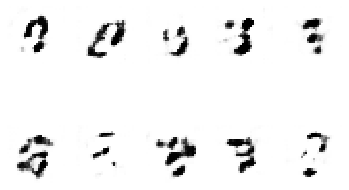

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.40625, 0.5703125, 0.4921875
1 / 100: 0.53125, 0.5625, 0.41796875
2 / 100: 0.5625, 0.3515625, 0.46484375
3 / 100: 0.484375, 0.375, 0.48828125
4 / 100: 0.5, 0.5703125, 0.48046875
5 / 100: 0.5546875, 0.484375, 0.4609375
6 / 100: 0.4921875, 0.4609375, 0.4296875
7 / 100: 0.515625, 0.5, 0.4765625
8 / 100: 0.4921875, 0.625, 0.44921875
9 / 100: 0.515625, 0.6171875, 0.4609375
10 / 100: 0.6171875, 0.4921875, 0.359375
11 / 100: 0.453125, 0.421875, 0.453125
12 / 100: 0.4453125, 0.40625, 0.47265625
13 / 100: 0.5, 0.5, 0.4609375
14 / 100: 0.46875, 0.4375, 0.46484375
15 / 100: 0.453125, 0.4609375, 0.4296875
16 / 100: 0.421875, 0.46875, 0.40234375
17 / 100: 0.4765625, 0.578125, 0.40234375
18 / 100: 0.515625, 0.5, 0.46484375
19 / 100: 0.609375, 0.5078125, 0.4765625
20 / 100: 0.5390625, 0.6171875, 0.4609375
21 / 100: 0.5234375, 0.4453125, 0.48046875
22 / 100: 0.6015625, 0.3984375, 0.4453125
23 / 100: 0.5078125, 0.47656

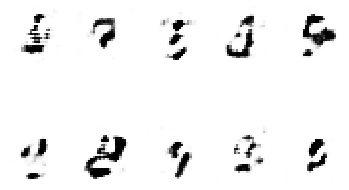

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.390625, 0.6015625, 0.41796875
1 / 100: 0.5703125, 0.59375, 0.42578125
2 / 100: 0.5625, 0.453125, 0.4453125
3 / 100: 0.5625, 0.3984375, 0.43359375
4 / 100: 0.5, 0.4453125, 0.4453125
5 / 100: 0.5703125, 0.46875, 0.42578125
6 / 100: 0.4609375, 0.484375, 0.36328125
7 / 100: 0.5390625, 0.46875, 0.36328125
8 / 100: 0.4921875, 0.5078125, 0.375
9 / 100: 0.4921875, 0.5234375, 0.40625
10 / 100: 0.4921875, 0.578125, 0.36328125
11 / 100: 0.4921875, 0.40625, 0.3671875
12 / 100: 0.65625, 0.5390625, 0.35546875
13 / 100: 0.4921875, 0.5234375, 0.4140625
14 / 100: 0.5859375, 0.5, 0.40625
15 / 100: 0.4375, 0.546875, 0.41015625
16 / 100: 0.578125, 0.46875, 0.4140625
17 / 100: 0.4453125, 0.5234375, 0.4140625
18 / 100: 0.5234375, 0.4375, 0.37890625
19 / 100: 0.5703125, 0.5078125, 0.359375
20 / 100: 0.421875, 0.6640625, 0.44921875
21 / 100: 0.515625, 0.484375, 0.3671875
22 / 100: 0.5078125, 0.546875, 0.44140625
23 / 100: 0.

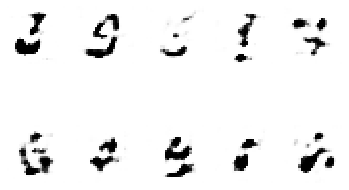

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5546875, 0.4921875, 0.328125
1 / 100: 0.59375, 0.546875, 0.37890625
2 / 100: 0.5, 0.4921875, 0.38671875
3 / 100: 0.5390625, 0.5859375, 0.421875
4 / 100: 0.5625, 0.6171875, 0.35546875
5 / 100: 0.5625, 0.4921875, 0.33984375
6 / 100: 0.5, 0.5, 0.375
7 / 100: 0.546875, 0.515625, 0.37109375
8 / 100: 0.515625, 0.5390625, 0.35546875
9 / 100: 0.5703125, 0.515625, 0.453125
10 / 100: 0.7109375, 0.5703125, 0.3515625
11 / 100: 0.6015625, 0.5390625, 0.37109375
12 / 100: 0.5, 0.5546875, 0.38671875
13 / 100: 0.53125, 0.515625, 0.41796875
14 / 100: 0.578125, 0.5, 0.41796875
15 / 100: 0.5859375, 0.5859375, 0.41015625
16 / 100: 0.5625, 0.53125, 0.375
17 / 100: 0.578125, 0.4609375, 0.36328125
18 / 100: 0.5625, 0.6015625, 0.35546875
19 / 100: 0.546875, 0.546875, 0.37109375
20 / 100: 0.5078125, 0.59375, 0.375
21 / 100: 0.5859375, 0.5390625, 0.390625
22 / 100: 0.578125, 0.5546875, 0.3828125
23 / 100: 0.5078125, 0.5390625, 

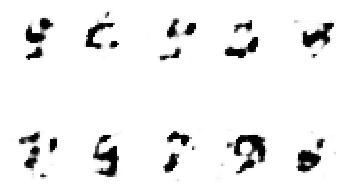

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.578125, 0.578125, 0.37109375
1 / 100: 0.53125, 0.6171875, 0.30078125
2 / 100: 0.6015625, 0.5078125, 0.421875
3 / 100: 0.5, 0.5234375, 0.421875
4 / 100: 0.5546875, 0.546875, 0.47265625
5 / 100: 0.609375, 0.484375, 0.3359375
6 / 100: 0.640625, 0.546875, 0.375
7 / 100: 0.5625, 0.5703125, 0.35546875
8 / 100: 0.546875, 0.5234375, 0.3671875
9 / 100: 0.640625, 0.515625, 0.37890625
10 / 100: 0.609375, 0.5234375, 0.33203125
11 / 100: 0.4921875, 0.53125, 0.3203125
12 / 100: 0.515625, 0.625, 0.40234375
13 / 100: 0.5859375, 0.65625, 0.39453125
14 / 100: 0.5859375, 0.546875, 0.38671875
15 / 100: 0.5625, 0.625, 0.29296875
16 / 100: 0.53125, 0.59375, 0.34375
17 / 100: 0.609375, 0.53125, 0.34765625
18 / 100: 0.53125, 0.59375, 0.359375
19 / 100: 0.5625, 0.5078125, 0.39453125
20 / 100: 0.53125, 0.6015625, 0.35546875
21 / 100: 0.5859375, 0.5234375, 0.3203125
22 / 100: 0.5234375, 0.5859375, 0.37890625
23 / 100: 0.484375,

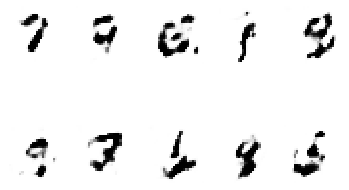

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5078125, 0.609375, 0.3828125
1 / 100: 0.4765625, 0.6484375, 0.40625
2 / 100: 0.546875, 0.453125, 0.38671875
3 / 100: 0.5546875, 0.5859375, 0.359375
4 / 100: 0.5703125, 0.5546875, 0.3515625
5 / 100: 0.6015625, 0.5703125, 0.375
6 / 100: 0.4453125, 0.6875, 0.38671875
7 / 100: 0.5859375, 0.5859375, 0.42578125
8 / 100: 0.53125, 0.609375, 0.4140625
9 / 100: 0.6015625, 0.5859375, 0.34765625
10 / 100: 0.6015625, 0.6015625, 0.328125
11 / 100: 0.6484375, 0.515625, 0.296875
12 / 100: 0.6015625, 0.5703125, 0.3515625
13 / 100: 0.5, 0.5703125, 0.37890625
14 / 100: 0.6875, 0.5859375, 0.421875
15 / 100: 0.53125, 0.53125, 0.35546875
16 / 100: 0.578125, 0.6015625, 0.4375
17 / 100: 0.640625, 0.46875, 0.390625
18 / 100: 0.546875, 0.6015625, 0.4140625
19 / 100: 0.53125, 0.5390625, 0.31640625
20 / 100: 0.5390625, 0.546875, 0.35546875
21 / 100: 0.640625, 0.59375, 0.3984375
22 / 100: 0.53125, 0.5, 0.3671875
23 / 100: 0.60156

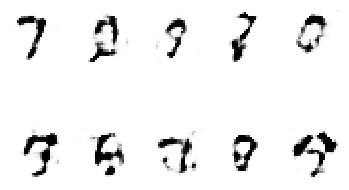

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.6171875, 0.46875, 0.3828125
1 / 100: 0.5, 0.6015625, 0.33984375
2 / 100: 0.5390625, 0.578125, 0.4140625
3 / 100: 0.5546875, 0.5546875, 0.4140625
4 / 100: 0.578125, 0.5390625, 0.35546875
5 / 100: 0.5, 0.6328125, 0.37109375
6 / 100: 0.578125, 0.5390625, 0.38671875
7 / 100: 0.65625, 0.5078125, 0.359375
8 / 100: 0.5546875, 0.59375, 0.34375
9 / 100: 0.453125, 0.4921875, 0.41015625
10 / 100: 0.59375, 0.6171875, 0.375
11 / 100: 0.4609375, 0.5859375, 0.36328125
12 / 100: 0.5625, 0.53125, 0.390625
13 / 100: 0.6015625, 0.484375, 0.39453125
14 / 100: 0.515625, 0.5, 0.3828125
15 / 100: 0.546875, 0.5859375, 0.36328125
16 / 100: 0.5, 0.5234375, 0.3828125
17 / 100: 0.4921875, 0.5234375, 0.33984375
18 / 100: 0.5546875, 0.4609375, 0.37109375
19 / 100: 0.53125, 0.5390625, 0.35546875
20 / 100: 0.5078125, 0.421875, 0.40234375
21 / 100: 0.5859375, 0.5703125, 0.390625
22 / 100: 0.5625, 0.5, 0.390625
23 / 100: 0.546875, 0.5

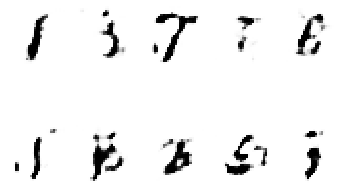

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.6015625, 0.546875, 0.36328125
1 / 100: 0.5390625, 0.5546875, 0.32421875
2 / 100: 0.515625, 0.59375, 0.3203125
3 / 100: 0.5078125, 0.5546875, 0.44140625
4 / 100: 0.4609375, 0.5859375, 0.41015625
5 / 100: 0.6015625, 0.4765625, 0.3828125
6 / 100: 0.59375, 0.515625, 0.31640625
7 / 100: 0.5625, 0.5390625, 0.3671875
8 / 100: 0.5390625, 0.53125, 0.33203125
9 / 100: 0.625, 0.546875, 0.390625
10 / 100: 0.4921875, 0.515625, 0.359375
11 / 100: 0.6171875, 0.4921875, 0.37890625
12 / 100: 0.484375, 0.5234375, 0.44140625
13 / 100: 0.5078125, 0.625, 0.3828125
14 / 100: 0.6171875, 0.515625, 0.375
15 / 100: 0.5546875, 0.5703125, 0.3203125
16 / 100: 0.515625, 0.546875, 0.421875
17 / 100: 0.6640625, 0.546875, 0.37890625
18 / 100: 0.5859375, 0.65625, 0.375
19 / 100: 0.6015625, 0.5, 0.33203125
20 / 100: 0.609375, 0.515625, 0.3671875
21 / 100: 0.6171875, 0.484375, 0.34765625
22 / 100: 0.4921875, 0.5703125, 0.3671875
23 / 10

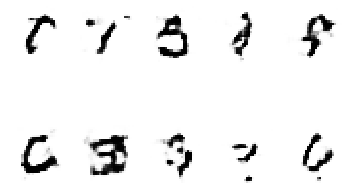

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.4765625, 0.46875, 0.3671875
1 / 100: 0.546875, 0.5703125, 0.375
2 / 100: 0.5625, 0.484375, 0.3359375
3 / 100: 0.515625, 0.6171875, 0.359375
4 / 100: 0.578125, 0.59375, 0.36328125
5 / 100: 0.484375, 0.5390625, 0.36328125
6 / 100: 0.5546875, 0.5234375, 0.390625
7 / 100: 0.578125, 0.5546875, 0.33203125
8 / 100: 0.5390625, 0.578125, 0.4140625
9 / 100: 0.4921875, 0.5859375, 0.2734375
10 / 100: 0.4765625, 0.59375, 0.36328125
11 / 100: 0.5, 0.5234375, 0.3984375
12 / 100: 0.5234375, 0.390625, 0.34765625
13 / 100: 0.5546875, 0.4375, 0.4140625
14 / 100: 0.40625, 0.5546875, 0.421875
15 / 100: 0.5, 0.53125, 0.421875
16 / 100: 0.5546875, 0.40625, 0.3125
17 / 100: 0.4765625, 0.671875, 0.43359375
18 / 100: 0.5390625, 0.46875, 0.359375
19 / 100: 0.484375, 0.578125, 0.38671875
20 / 100: 0.46875, 0.4609375, 0.4453125
21 / 100: 0.59375, 0.484375, 0.453125
22 / 100: 0.484375, 0.5, 0.34375
23 / 100: 0.671875, 0.5703125, 0

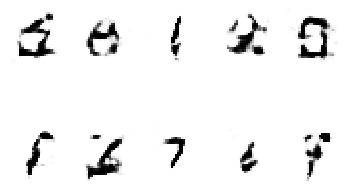

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.4453125, 0.5859375, 0.375
1 / 100: 0.453125, 0.453125, 0.3671875
2 / 100: 0.5078125, 0.6484375, 0.36328125
3 / 100: 0.5234375, 0.5703125, 0.41796875
4 / 100: 0.5625, 0.5703125, 0.40625
5 / 100: 0.4765625, 0.515625, 0.4296875
6 / 100: 0.65625, 0.5078125, 0.39453125
7 / 100: 0.578125, 0.515625, 0.37109375
8 / 100: 0.484375, 0.5546875, 0.4140625
9 / 100: 0.5, 0.5390625, 0.3671875
10 / 100: 0.4375, 0.5078125, 0.44140625
11 / 100: 0.5078125, 0.4453125, 0.4296875
12 / 100: 0.5390625, 0.59375, 0.46875
13 / 100: 0.484375, 0.4609375, 0.48828125
14 / 100: 0.6015625, 0.453125, 0.40234375
15 / 100: 0.5546875, 0.453125, 0.39453125
16 / 100: 0.5546875, 0.5078125, 0.41015625
17 / 100: 0.5625, 0.5390625, 0.33984375
18 / 100: 0.546875, 0.6328125, 0.41015625
19 / 100: 0.4765625, 0.5703125, 0.3984375
20 / 100: 0.5703125, 0.5859375, 0.40625
21 / 100: 0.5625, 0.5390625, 0.40234375
22 / 100: 0.5390625, 0.5625, 0.47265625
2

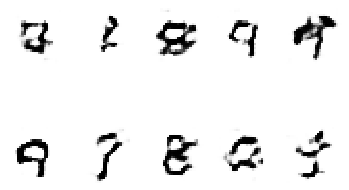

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5, 0.5078125, 0.3828125
1 / 100: 0.59375, 0.546875, 0.42578125
2 / 100: 0.5078125, 0.4921875, 0.4609375
3 / 100: 0.6015625, 0.5703125, 0.42578125
4 / 100: 0.5, 0.4609375, 0.41015625
5 / 100: 0.4765625, 0.5, 0.3984375
6 / 100: 0.46875, 0.5390625, 0.42578125
7 / 100: 0.5703125, 0.40625, 0.3515625
8 / 100: 0.5546875, 0.65625, 0.390625
9 / 100: 0.59375, 0.421875, 0.40625
10 / 100: 0.5234375, 0.4609375, 0.421875
11 / 100: 0.578125, 0.5546875, 0.36328125
12 / 100: 0.5234375, 0.5390625, 0.38671875
13 / 100: 0.5, 0.5546875, 0.37890625
14 / 100: 0.46875, 0.546875, 0.43359375
15 / 100: 0.5546875, 0.484375, 0.4375
16 / 100: 0.59375, 0.484375, 0.37109375
17 / 100: 0.609375, 0.4453125, 0.41796875
18 / 100: 0.5, 0.5390625, 0.4296875
19 / 100: 0.46875, 0.578125, 0.42578125
20 / 100: 0.4921875, 0.6015625, 0.37890625
21 / 100: 0.5703125, 0.5234375, 0.4140625
22 / 100: 0.5, 0.53125, 0.37109375
23 / 100: 0.5625, 0.55468

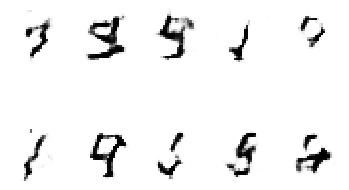

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.53125, 0.515625, 0.4375
1 / 100: 0.59375, 0.5859375, 0.43359375
2 / 100: 0.5, 0.453125, 0.42578125
3 / 100: 0.5625, 0.5546875, 0.453125
4 / 100: 0.5078125, 0.515625, 0.4609375
5 / 100: 0.578125, 0.5234375, 0.38671875
6 / 100: 0.34375, 0.421875, 0.38671875
7 / 100: 0.5859375, 0.5859375, 0.453125
8 / 100: 0.5, 0.4609375, 0.44140625
9 / 100: 0.609375, 0.5234375, 0.44140625
10 / 100: 0.5625, 0.625, 0.4765625
11 / 100: 0.515625, 0.6171875, 0.47265625
12 / 100: 0.5234375, 0.4921875, 0.3828125
13 / 100: 0.5859375, 0.453125, 0.4296875
14 / 100: 0.6640625, 0.640625, 0.3828125
15 / 100: 0.6171875, 0.5390625, 0.40234375
16 / 100: 0.5703125, 0.4921875, 0.38671875
17 / 100: 0.484375, 0.5703125, 0.33984375
18 / 100: 0.53125, 0.53125, 0.42578125
19 / 100: 0.53125, 0.546875, 0.375
20 / 100: 0.4921875, 0.5859375, 0.42578125
21 / 100: 0.4921875, 0.515625, 0.46484375
22 / 100: 0.5546875, 0.5078125, 0.453125
23 / 100: 0.

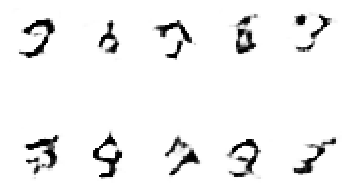

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.4765625, 0.4921875, 0.42578125
1 / 100: 0.5078125, 0.5078125, 0.4296875
2 / 100: 0.515625, 0.5234375, 0.44140625
3 / 100: 0.59375, 0.4140625, 0.38671875
4 / 100: 0.4765625, 0.5625, 0.38671875
5 / 100: 0.5859375, 0.5625, 0.421875
6 / 100: 0.4921875, 0.453125, 0.375
7 / 100: 0.6171875, 0.5078125, 0.3203125
8 / 100: 0.578125, 0.59375, 0.390625
9 / 100: 0.515625, 0.546875, 0.36328125
10 / 100: 0.4765625, 0.4765625, 0.40234375
11 / 100: 0.5, 0.6171875, 0.3984375
12 / 100: 0.53125, 0.4765625, 0.4140625
13 / 100: 0.4375, 0.5234375, 0.3671875
14 / 100: 0.5703125, 0.4921875, 0.40234375
15 / 100: 0.5625, 0.5859375, 0.3515625
16 / 100: 0.5859375, 0.5703125, 0.37109375
17 / 100: 0.5234375, 0.5234375, 0.359375
18 / 100: 0.4921875, 0.5546875, 0.421875
19 / 100: 0.4453125, 0.515625, 0.41015625
20 / 100: 0.5703125, 0.4765625, 0.40625
21 / 100: 0.53125, 0.515625, 0.41796875
22 / 100: 0.5546875, 0.5625, 0.4296875
23 / 

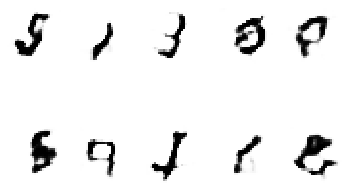

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5390625, 0.609375, 0.4375
1 / 100: 0.5703125, 0.46875, 0.40234375
2 / 100: 0.6640625, 0.5703125, 0.44140625
3 / 100: 0.53125, 0.4921875, 0.44140625
4 / 100: 0.5859375, 0.4609375, 0.3984375
5 / 100: 0.5546875, 0.5078125, 0.33203125
6 / 100: 0.46875, 0.5390625, 0.35546875
7 / 100: 0.421875, 0.6015625, 0.33203125
8 / 100: 0.546875, 0.5234375, 0.41015625
9 / 100: 0.5, 0.5625, 0.46484375
10 / 100: 0.578125, 0.515625, 0.40625
11 / 100: 0.5859375, 0.4609375, 0.37109375
12 / 100: 0.5859375, 0.6328125, 0.34375
13 / 100: 0.5390625, 0.546875, 0.4296875
14 / 100: 0.4609375, 0.5, 0.39453125
15 / 100: 0.5390625, 0.53125, 0.48046875
16 / 100: 0.5703125, 0.5859375, 0.44140625
17 / 100: 0.515625, 0.484375, 0.41015625
18 / 100: 0.4453125, 0.53125, 0.421875
19 / 100: 0.5078125, 0.578125, 0.40625
20 / 100: 0.53125, 0.453125, 0.43359375
21 / 100: 0.515625, 0.484375, 0.3515625
22 / 100: 0.5078125, 0.5703125, 0.40625
23 / 1

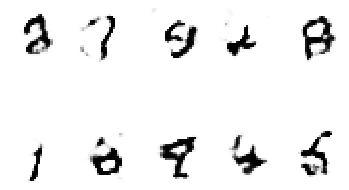

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5, 0.609375, 0.421875
1 / 100: 0.515625, 0.46875, 0.40625
2 / 100: 0.53125, 0.53125, 0.44140625
3 / 100: 0.46875, 0.4921875, 0.42578125
4 / 100: 0.5078125, 0.5546875, 0.41015625
5 / 100: 0.5234375, 0.5703125, 0.41015625
6 / 100: 0.46875, 0.546875, 0.45703125
7 / 100: 0.578125, 0.484375, 0.4140625
8 / 100: 0.4921875, 0.5, 0.3984375
9 / 100: 0.53125, 0.4140625, 0.42578125
10 / 100: 0.5546875, 0.453125, 0.39453125
11 / 100: 0.6015625, 0.53125, 0.375
12 / 100: 0.4609375, 0.453125, 0.4296875
13 / 100: 0.5703125, 0.5234375, 0.41015625
14 / 100: 0.5390625, 0.4609375, 0.40625
15 / 100: 0.53125, 0.5, 0.390625
16 / 100: 0.5, 0.5, 0.375
17 / 100: 0.4609375, 0.46875, 0.4609375
18 / 100: 0.515625, 0.515625, 0.4140625
19 / 100: 0.5390625, 0.5, 0.3828125
20 / 100: 0.4921875, 0.4921875, 0.3671875
21 / 100: 0.4296875, 0.4609375, 0.4140625
22 / 100: 0.5, 0.4921875, 0.41015625
23 / 100: 0.4609375, 0.5390625, 0.41015625


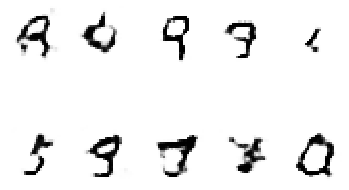

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5234375, 0.5546875, 0.37109375
1 / 100: 0.453125, 0.5859375, 0.390625
2 / 100: 0.5, 0.515625, 0.39453125
3 / 100: 0.5078125, 0.5546875, 0.359375
4 / 100: 0.578125, 0.546875, 0.44140625
5 / 100: 0.453125, 0.546875, 0.39453125
6 / 100: 0.53125, 0.546875, 0.46875
7 / 100: 0.515625, 0.4921875, 0.44921875
8 / 100: 0.625, 0.4609375, 0.453125
9 / 100: 0.4453125, 0.6171875, 0.45703125
10 / 100: 0.6171875, 0.515625, 0.44140625
11 / 100: 0.578125, 0.6015625, 0.41796875
12 / 100: 0.515625, 0.5390625, 0.4453125
13 / 100: 0.5390625, 0.484375, 0.3984375
14 / 100: 0.5859375, 0.53125, 0.37890625
15 / 100: 0.4921875, 0.5, 0.41796875
16 / 100: 0.4765625, 0.5234375, 0.390625
17 / 100: 0.46875, 0.578125, 0.484375
18 / 100: 0.5, 0.5, 0.4140625
19 / 100: 0.5546875, 0.5625, 0.3828125
20 / 100: 0.4765625, 0.53125, 0.41796875
21 / 100: 0.5703125, 0.5859375, 0.375
22 / 100: 0.546875, 0.46875, 0.38671875
23 / 100: 0.4453125, 0.

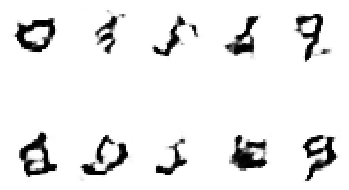

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.4765625, 0.4921875, 0.37890625
1 / 100: 0.4765625, 0.453125, 0.44140625
2 / 100: 0.4921875, 0.5078125, 0.3828125
3 / 100: 0.5625, 0.53125, 0.40625
4 / 100: 0.4609375, 0.46875, 0.34765625
5 / 100: 0.5, 0.5703125, 0.40625
6 / 100: 0.609375, 0.453125, 0.4140625
7 / 100: 0.453125, 0.53125, 0.3984375
8 / 100: 0.5078125, 0.5390625, 0.37109375
9 / 100: 0.578125, 0.515625, 0.4296875
10 / 100: 0.5546875, 0.4609375, 0.4453125
11 / 100: 0.453125, 0.6171875, 0.4296875
12 / 100: 0.5390625, 0.5390625, 0.42578125
13 / 100: 0.515625, 0.484375, 0.3984375
14 / 100: 0.546875, 0.5390625, 0.4296875
15 / 100: 0.6015625, 0.4609375, 0.40625
16 / 100: 0.546875, 0.53125, 0.4375
17 / 100: 0.546875, 0.5078125, 0.41796875
18 / 100: 0.4765625, 0.5859375, 0.39453125
19 / 100: 0.4921875, 0.5625, 0.32421875
20 / 100: 0.4453125, 0.5859375, 0.4453125
21 / 100: 0.53125, 0.4609375, 0.4296875
22 / 100: 0.53125, 0.5234375, 0.4375
23 / 100:

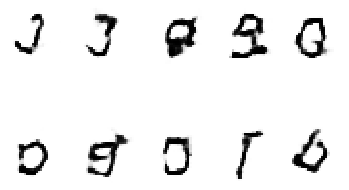

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.453125, 0.5390625, 0.45703125
1 / 100: 0.515625, 0.484375, 0.43359375
2 / 100: 0.4609375, 0.53125, 0.38671875
3 / 100: 0.4921875, 0.4609375, 0.4375
4 / 100: 0.6171875, 0.515625, 0.40625
5 / 100: 0.5234375, 0.5390625, 0.4453125
6 / 100: 0.4296875, 0.4921875, 0.45703125
7 / 100: 0.578125, 0.40625, 0.359375
8 / 100: 0.5234375, 0.484375, 0.4140625
9 / 100: 0.5078125, 0.515625, 0.3984375
10 / 100: 0.5234375, 0.5, 0.37109375
11 / 100: 0.421875, 0.5, 0.34765625
12 / 100: 0.4609375, 0.53125, 0.390625
13 / 100: 0.5546875, 0.515625, 0.34765625
14 / 100: 0.5, 0.484375, 0.38671875
15 / 100: 0.53125, 0.4453125, 0.36328125
16 / 100: 0.4921875, 0.5078125, 0.37109375
17 / 100: 0.4921875, 0.625, 0.34765625
18 / 100: 0.6640625, 0.4375, 0.39453125
19 / 100: 0.4375, 0.5546875, 0.390625
20 / 100: 0.53125, 0.46875, 0.44921875
21 / 100: 0.609375, 0.4765625, 0.44140625
22 / 100: 0.5625, 0.5859375, 0.4140625
23 / 100: 0.46093

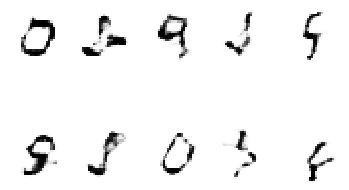

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.4765625, 0.5625, 0.34765625
1 / 100: 0.5859375, 0.484375, 0.421875
2 / 100: 0.546875, 0.5703125, 0.37890625
3 / 100: 0.5390625, 0.53125, 0.4453125
4 / 100: 0.5390625, 0.5, 0.37890625
5 / 100: 0.5390625, 0.4609375, 0.36328125
6 / 100: 0.4765625, 0.5859375, 0.4453125
7 / 100: 0.5234375, 0.5234375, 0.421875
8 / 100: 0.578125, 0.4921875, 0.41015625
9 / 100: 0.5390625, 0.5625, 0.45703125
10 / 100: 0.515625, 0.5546875, 0.47265625
11 / 100: 0.640625, 0.53125, 0.46484375
12 / 100: 0.53125, 0.4765625, 0.41796875
13 / 100: 0.5078125, 0.4921875, 0.44921875
14 / 100: 0.4609375, 0.5703125, 0.375
15 / 100: 0.5546875, 0.4765625, 0.3984375
16 / 100: 0.5078125, 0.484375, 0.41015625
17 / 100: 0.5, 0.4609375, 0.4375
18 / 100: 0.59375, 0.515625, 0.42578125
19 / 100: 0.515625, 0.375, 0.44921875
20 / 100: 0.53125, 0.515625, 0.42578125
21 / 100: 0.5703125, 0.5234375, 0.43359375
22 / 100: 0.5234375, 0.484375, 0.36328125
23 /

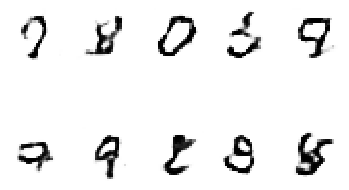

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5703125, 0.5, 0.36328125
1 / 100: 0.421875, 0.640625, 0.40625
2 / 100: 0.5, 0.4765625, 0.41796875
3 / 100: 0.5, 0.46875, 0.4453125
4 / 100: 0.625, 0.5078125, 0.40234375
5 / 100: 0.515625, 0.609375, 0.42578125
6 / 100: 0.4921875, 0.4765625, 0.35546875
7 / 100: 0.4453125, 0.4453125, 0.43359375
8 / 100: 0.4765625, 0.4453125, 0.4453125
9 / 100: 0.4921875, 0.5078125, 0.3828125
10 / 100: 0.5390625, 0.515625, 0.36328125
11 / 100: 0.5546875, 0.5, 0.390625
12 / 100: 0.5, 0.484375, 0.3828125
13 / 100: 0.5234375, 0.484375, 0.375
14 / 100: 0.484375, 0.5390625, 0.38671875
15 / 100: 0.4921875, 0.421875, 0.34765625
16 / 100: 0.5234375, 0.578125, 0.40234375
17 / 100: 0.46875, 0.453125, 0.390625
18 / 100: 0.4921875, 0.546875, 0.41015625
19 / 100: 0.625, 0.515625, 0.46484375
20 / 100: 0.5703125, 0.4609375, 0.4140625
21 / 100: 0.46875, 0.546875, 0.44921875
22 / 100: 0.5234375, 0.4921875, 0.38671875
23 / 100: 0.5546875, 

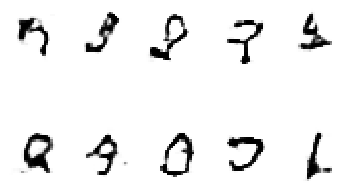

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.546875, 0.5234375, 0.4375
1 / 100: 0.4375, 0.515625, 0.37890625
2 / 100: 0.53125, 0.453125, 0.453125
3 / 100: 0.5625, 0.46875, 0.37109375
4 / 100: 0.5546875, 0.546875, 0.37109375
5 / 100: 0.453125, 0.4765625, 0.3515625
6 / 100: 0.546875, 0.453125, 0.3828125
7 / 100: 0.4921875, 0.5234375, 0.3515625
8 / 100: 0.46875, 0.5234375, 0.4296875
9 / 100: 0.546875, 0.53125, 0.375
10 / 100: 0.5703125, 0.453125, 0.3671875
11 / 100: 0.5546875, 0.453125, 0.390625
12 / 100: 0.5546875, 0.6015625, 0.40234375
13 / 100: 0.3671875, 0.5390625, 0.4140625
14 / 100: 0.6484375, 0.4765625, 0.3359375
15 / 100: 0.5390625, 0.4921875, 0.40625
16 / 100: 0.515625, 0.5390625, 0.3984375
17 / 100: 0.5078125, 0.5234375, 0.37890625
18 / 100: 0.5078125, 0.53125, 0.3828125
19 / 100: 0.546875, 0.4296875, 0.39453125
20 / 100: 0.46875, 0.515625, 0.3671875
21 / 100: 0.5625, 0.484375, 0.37890625
22 / 100: 0.5625, 0.484375, 0.40234375
23 / 100: 0

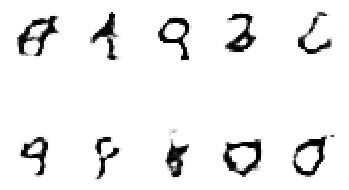

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5078125, 0.484375, 0.3671875
1 / 100: 0.515625, 0.4453125, 0.39453125
2 / 100: 0.4765625, 0.5078125, 0.37109375
3 / 100: 0.4765625, 0.5234375, 0.4296875
4 / 100: 0.515625, 0.421875, 0.42578125
5 / 100: 0.5546875, 0.53125, 0.4375
6 / 100: 0.546875, 0.5078125, 0.421875
7 / 100: 0.5, 0.53125, 0.359375
8 / 100: 0.578125, 0.4921875, 0.3515625
9 / 100: 0.421875, 0.4375, 0.375
10 / 100: 0.5546875, 0.4609375, 0.421875
11 / 100: 0.484375, 0.390625, 0.4296875
12 / 100: 0.578125, 0.4375, 0.35546875
13 / 100: 0.5546875, 0.453125, 0.359375
14 / 100: 0.375, 0.6171875, 0.36328125
15 / 100: 0.3671875, 0.578125, 0.3984375
16 / 100: 0.4921875, 0.484375, 0.35546875
17 / 100: 0.5078125, 0.5703125, 0.45703125
18 / 100: 0.5, 0.4453125, 0.46875
19 / 100: 0.5390625, 0.5, 0.37890625
20 / 100: 0.5234375, 0.453125, 0.40625
21 / 100: 0.609375, 0.53125, 0.46484375
22 / 100: 0.4453125, 0.4453125, 0.42578125
23 / 100: 0.5546875, 0.

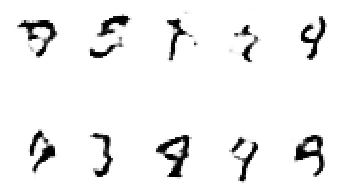

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.4453125, 0.5234375, 0.359375
1 / 100: 0.4765625, 0.4765625, 0.4609375
2 / 100: 0.46875, 0.4296875, 0.43359375
3 / 100: 0.40625, 0.5625, 0.390625
4 / 100: 0.4609375, 0.3984375, 0.3984375
5 / 100: 0.5234375, 0.515625, 0.39453125
6 / 100: 0.4375, 0.578125, 0.40625
7 / 100: 0.5859375, 0.5, 0.48046875
8 / 100: 0.515625, 0.484375, 0.44140625
9 / 100: 0.4609375, 0.5078125, 0.40625
10 / 100: 0.5078125, 0.546875, 0.42578125
11 / 100: 0.5390625, 0.4921875, 0.44140625
12 / 100: 0.5703125, 0.546875, 0.4140625
13 / 100: 0.4921875, 0.5, 0.39453125
14 / 100: 0.5, 0.5390625, 0.3984375
15 / 100: 0.578125, 0.4609375, 0.4140625
16 / 100: 0.5390625, 0.484375, 0.40234375
17 / 100: 0.515625, 0.6171875, 0.39453125
18 / 100: 0.5078125, 0.5859375, 0.42578125
19 / 100: 0.5546875, 0.5078125, 0.42578125
20 / 100: 0.609375, 0.4921875, 0.35546875
21 / 100: 0.46875, 0.5546875, 0.359375
22 / 100: 0.4921875, 0.5625, 0.390625
23 / 100

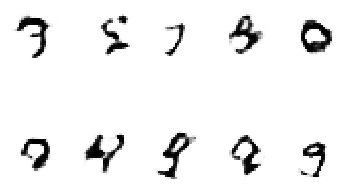

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.4609375, 0.4921875, 0.41796875
1 / 100: 0.46875, 0.4921875, 0.3828125
2 / 100: 0.59375, 0.4296875, 0.3203125
3 / 100: 0.515625, 0.4765625, 0.34765625
4 / 100: 0.5234375, 0.4921875, 0.36328125
5 / 100: 0.5234375, 0.390625, 0.359375
6 / 100: 0.546875, 0.5, 0.4453125
7 / 100: 0.4921875, 0.5390625, 0.37109375
8 / 100: 0.4921875, 0.46875, 0.41796875
9 / 100: 0.5390625, 0.53125, 0.41015625
10 / 100: 0.5078125, 0.3984375, 0.4609375
11 / 100: 0.5234375, 0.4375, 0.4375
12 / 100: 0.46875, 0.578125, 0.37890625
13 / 100: 0.4765625, 0.5390625, 0.4296875
14 / 100: 0.515625, 0.609375, 0.4375
15 / 100: 0.5703125, 0.5234375, 0.40234375
16 / 100: 0.53125, 0.546875, 0.3671875
17 / 100: 0.515625, 0.4375, 0.4375
18 / 100: 0.59375, 0.5390625, 0.3828125
19 / 100: 0.6015625, 0.3828125, 0.41796875
20 / 100: 0.5078125, 0.5, 0.38671875
21 / 100: 0.484375, 0.6015625, 0.41015625
22 / 100: 0.4296875, 0.5078125, 0.37109375
23 / 100

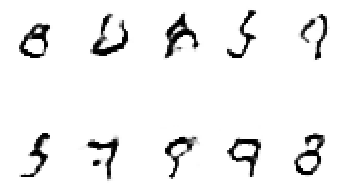

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5390625, 0.515625, 0.4375
1 / 100: 0.53125, 0.515625, 0.4296875
2 / 100: 0.515625, 0.53125, 0.34375
3 / 100: 0.4453125, 0.5390625, 0.43359375
4 / 100: 0.453125, 0.4453125, 0.4921875
5 / 100: 0.53125, 0.4375, 0.42578125
6 / 100: 0.5078125, 0.453125, 0.42578125
7 / 100: 0.5234375, 0.5546875, 0.42578125
8 / 100: 0.4375, 0.5, 0.4375
9 / 100: 0.546875, 0.515625, 0.41796875
10 / 100: 0.4765625, 0.40625, 0.3984375
11 / 100: 0.5, 0.4921875, 0.4296875
12 / 100: 0.4296875, 0.484375, 0.4375
13 / 100: 0.5234375, 0.5, 0.39453125
14 / 100: 0.5, 0.5, 0.453125
15 / 100: 0.5, 0.5390625, 0.40625
16 / 100: 0.53125, 0.5546875, 0.38671875
17 / 100: 0.5, 0.4609375, 0.42578125
18 / 100: 0.4609375, 0.46875, 0.30859375
19 / 100: 0.5234375, 0.5703125, 0.39453125
20 / 100: 0.4765625, 0.46875, 0.38671875
21 / 100: 0.46875, 0.5390625, 0.42578125
22 / 100: 0.46875, 0.578125, 0.3984375
23 / 100: 0.5625, 0.5703125, 0.4453125
24 / 10

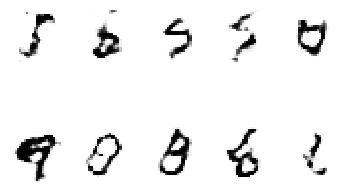

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.453125, 0.53125, 0.40625
1 / 100: 0.5703125, 0.5625, 0.40234375
2 / 100: 0.5, 0.546875, 0.46484375
3 / 100: 0.5859375, 0.5390625, 0.45703125
4 / 100: 0.5703125, 0.484375, 0.39453125
5 / 100: 0.4765625, 0.484375, 0.41796875
6 / 100: 0.6015625, 0.484375, 0.36328125
7 / 100: 0.5234375, 0.546875, 0.47265625
8 / 100: 0.5234375, 0.4765625, 0.46875
9 / 100: 0.53125, 0.5, 0.3828125
10 / 100: 0.484375, 0.5390625, 0.40625
11 / 100: 0.4921875, 0.4453125, 0.39453125
12 / 100: 0.4921875, 0.546875, 0.4453125
13 / 100: 0.59375, 0.5234375, 0.375
14 / 100: 0.421875, 0.5078125, 0.46484375
15 / 100: 0.546875, 0.4765625, 0.453125
16 / 100: 0.515625, 0.484375, 0.4375
17 / 100: 0.5234375, 0.3671875, 0.4140625
18 / 100: 0.4765625, 0.4609375, 0.41015625
19 / 100: 0.5390625, 0.4609375, 0.40625
20 / 100: 0.40625, 0.453125, 0.44921875
21 / 100: 0.5234375, 0.4921875, 0.37109375
22 / 100: 0.5078125, 0.5078125, 0.4765625
23 / 100:

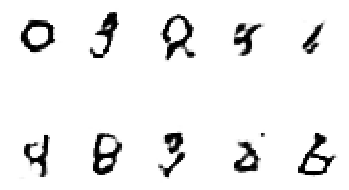

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.4921875, 0.5078125, 0.4296875
1 / 100: 0.515625, 0.4765625, 0.40625
2 / 100: 0.5078125, 0.6484375, 0.44140625
3 / 100: 0.4609375, 0.5, 0.4296875
4 / 100: 0.4921875, 0.4453125, 0.42578125
5 / 100: 0.515625, 0.515625, 0.4765625
6 / 100: 0.5625, 0.453125, 0.42578125
7 / 100: 0.4375, 0.4453125, 0.43359375
8 / 100: 0.671875, 0.5859375, 0.390625
9 / 100: 0.4921875, 0.421875, 0.38671875
10 / 100: 0.4140625, 0.484375, 0.453125
11 / 100: 0.453125, 0.53125, 0.40625
12 / 100: 0.5625, 0.5390625, 0.3984375
13 / 100: 0.5390625, 0.4140625, 0.375
14 / 100: 0.546875, 0.5546875, 0.375
15 / 100: 0.5703125, 0.484375, 0.41796875
16 / 100: 0.4765625, 0.4609375, 0.4140625
17 / 100: 0.546875, 0.5078125, 0.3984375
18 / 100: 0.515625, 0.46875, 0.37890625
19 / 100: 0.546875, 0.4921875, 0.3828125
20 / 100: 0.4375, 0.53125, 0.3203125
21 / 100: 0.5234375, 0.4453125, 0.33203125
22 / 100: 0.4140625, 0.484375, 0.421875
23 / 100: 0.53

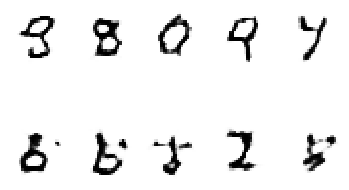

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5546875, 0.4921875, 0.3515625
1 / 100: 0.4609375, 0.4375, 0.33984375
2 / 100: 0.546875, 0.453125, 0.34765625
3 / 100: 0.3984375, 0.5625, 0.3984375
4 / 100: 0.5546875, 0.515625, 0.421875
5 / 100: 0.4375, 0.5234375, 0.38671875
6 / 100: 0.4765625, 0.6171875, 0.4140625
7 / 100: 0.4921875, 0.4453125, 0.40234375
8 / 100: 0.4921875, 0.515625, 0.39453125
9 / 100: 0.609375, 0.5390625, 0.42578125
10 / 100: 0.515625, 0.4765625, 0.43359375
11 / 100: 0.4296875, 0.5234375, 0.42578125
12 / 100: 0.4921875, 0.4765625, 0.4453125
13 / 100: 0.5, 0.4765625, 0.4609375
14 / 100: 0.4921875, 0.4765625, 0.390625
15 / 100: 0.4765625, 0.484375, 0.44921875
16 / 100: 0.4453125, 0.5390625, 0.42578125
17 / 100: 0.46875, 0.453125, 0.38671875
18 / 100: 0.5546875, 0.46875, 0.453125
19 / 100: 0.5, 0.5078125, 0.41015625
20 / 100: 0.453125, 0.453125, 0.453125
21 / 100: 0.53125, 0.46875, 0.4609375
22 / 100: 0.5390625, 0.453125, 0.421875
23

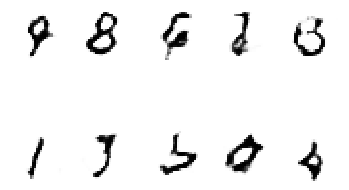

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.4609375, 0.3671875, 0.39453125
1 / 100: 0.515625, 0.4375, 0.42578125
2 / 100: 0.4140625, 0.4296875, 0.4140625
3 / 100: 0.4609375, 0.4375, 0.3828125
4 / 100: 0.546875, 0.390625, 0.34375
5 / 100: 0.453125, 0.515625, 0.46484375
6 / 100: 0.484375, 0.4921875, 0.38671875
7 / 100: 0.5234375, 0.6015625, 0.40625
8 / 100: 0.6015625, 0.4921875, 0.4296875
9 / 100: 0.578125, 0.484375, 0.38671875
10 / 100: 0.4765625, 0.4453125, 0.3046875
11 / 100: 0.5390625, 0.5703125, 0.4296875
12 / 100: 0.515625, 0.4453125, 0.4453125
13 / 100: 0.4453125, 0.46875, 0.3984375
14 / 100: 0.546875, 0.5703125, 0.37890625
15 / 100: 0.53125, 0.484375, 0.375
16 / 100: 0.390625, 0.453125, 0.390625
17 / 100: 0.4453125, 0.5703125, 0.390625
18 / 100: 0.5078125, 0.53125, 0.40625
19 / 100: 0.5234375, 0.484375, 0.41015625
20 / 100: 0.484375, 0.546875, 0.35546875
21 / 100: 0.4765625, 0.484375, 0.4296875
22 / 100: 0.53125, 0.4296875, 0.37890625
23 

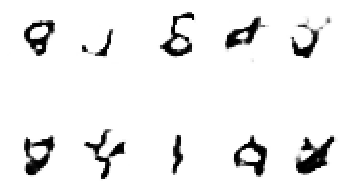

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5625, 0.4453125, 0.40625
1 / 100: 0.5078125, 0.53125, 0.3984375
2 / 100: 0.46875, 0.5, 0.4140625
3 / 100: 0.453125, 0.5390625, 0.40234375
4 / 100: 0.40625, 0.453125, 0.4140625
5 / 100: 0.4765625, 0.5390625, 0.390625
6 / 100: 0.5390625, 0.5078125, 0.3984375
7 / 100: 0.546875, 0.578125, 0.3671875
8 / 100: 0.5234375, 0.515625, 0.38671875
9 / 100: 0.515625, 0.4765625, 0.421875
10 / 100: 0.515625, 0.546875, 0.39453125
11 / 100: 0.4921875, 0.4609375, 0.44140625
12 / 100: 0.4453125, 0.53125, 0.3984375
13 / 100: 0.515625, 0.5, 0.453125
14 / 100: 0.5, 0.59375, 0.37890625
15 / 100: 0.5859375, 0.484375, 0.41015625
16 / 100: 0.546875, 0.515625, 0.44140625
17 / 100: 0.5859375, 0.5703125, 0.453125
18 / 100: 0.46875, 0.5390625, 0.41015625
19 / 100: 0.5390625, 0.4453125, 0.46875
20 / 100: 0.5234375, 0.4609375, 0.4140625
21 / 100: 0.5, 0.5625, 0.4609375
22 / 100: 0.5, 0.4296875, 0.40625
23 / 100: 0.4453125, 0.4921875,

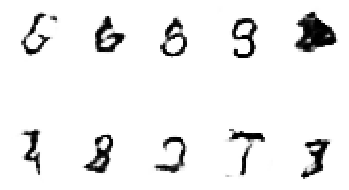

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.53125, 0.4375, 0.38671875
1 / 100: 0.5390625, 0.484375, 0.38671875
2 / 100: 0.4375, 0.53125, 0.44140625
3 / 100: 0.46875, 0.53125, 0.3671875
4 / 100: 0.421875, 0.4296875, 0.3984375
5 / 100: 0.5390625, 0.4140625, 0.40625
6 / 100: 0.5546875, 0.5234375, 0.41796875
7 / 100: 0.5703125, 0.5234375, 0.4453125
8 / 100: 0.4140625, 0.484375, 0.40625
9 / 100: 0.5078125, 0.546875, 0.4296875
10 / 100: 0.5546875, 0.4921875, 0.45703125
11 / 100: 0.546875, 0.4765625, 0.4140625
12 / 100: 0.4140625, 0.46875, 0.44921875
13 / 100: 0.5, 0.59375, 0.4609375
14 / 100: 0.484375, 0.484375, 0.39453125
15 / 100: 0.484375, 0.4921875, 0.3984375
16 / 100: 0.5546875, 0.4765625, 0.44921875
17 / 100: 0.515625, 0.46875, 0.48828125
18 / 100: 0.5, 0.4765625, 0.39453125
19 / 100: 0.5, 0.5234375, 0.42578125
20 / 100: 0.515625, 0.453125, 0.3984375
21 / 100: 0.5234375, 0.5625, 0.33203125
22 / 100: 0.484375, 0.5234375, 0.421875
23 / 100: 0.460

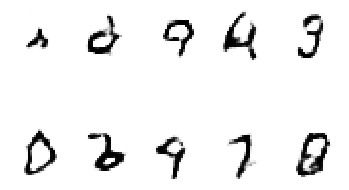

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.453125, 0.4296875, 0.421875
1 / 100: 0.59375, 0.5546875, 0.3828125
2 / 100: 0.46875, 0.5703125, 0.41015625
3 / 100: 0.4921875, 0.421875, 0.51171875
4 / 100: 0.4765625, 0.484375, 0.51171875
5 / 100: 0.53125, 0.484375, 0.453125
6 / 100: 0.4453125, 0.5, 0.421875
7 / 100: 0.5859375, 0.421875, 0.43359375
8 / 100: 0.453125, 0.5078125, 0.4375
9 / 100: 0.5234375, 0.4453125, 0.46484375
10 / 100: 0.5078125, 0.515625, 0.36328125
11 / 100: 0.4453125, 0.5078125, 0.41015625
12 / 100: 0.5234375, 0.46875, 0.4296875
13 / 100: 0.4921875, 0.5390625, 0.4140625
14 / 100: 0.5234375, 0.5703125, 0.43359375
15 / 100: 0.4921875, 0.4921875, 0.359375
16 / 100: 0.5390625, 0.5078125, 0.44140625
17 / 100: 0.546875, 0.5390625, 0.390625
18 / 100: 0.484375, 0.4453125, 0.45703125
19 / 100: 0.5078125, 0.4609375, 0.4609375
20 / 100: 0.5, 0.46875, 0.42578125
21 / 100: 0.46875, 0.5078125, 0.36328125
22 / 100: 0.4609375, 0.4765625, 0.417968

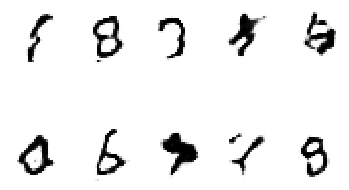

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.484375, 0.453125, 0.48046875
1 / 100: 0.5, 0.5546875, 0.40234375
2 / 100: 0.46875, 0.484375, 0.46484375
3 / 100: 0.53125, 0.4921875, 0.3984375
4 / 100: 0.515625, 0.515625, 0.4296875
5 / 100: 0.4609375, 0.4609375, 0.44140625
6 / 100: 0.421875, 0.4375, 0.3671875
7 / 100: 0.5625, 0.5234375, 0.41796875
8 / 100: 0.5078125, 0.421875, 0.41796875
9 / 100: 0.421875, 0.5234375, 0.37109375
10 / 100: 0.4921875, 0.484375, 0.38671875
11 / 100: 0.5, 0.5859375, 0.37109375
12 / 100: 0.5625, 0.4765625, 0.38671875
13 / 100: 0.4921875, 0.5390625, 0.35546875
14 / 100: 0.4609375, 0.5234375, 0.40234375
15 / 100: 0.59375, 0.4609375, 0.41796875
16 / 100: 0.5859375, 0.5625, 0.39453125
17 / 100: 0.421875, 0.4609375, 0.37109375
18 / 100: 0.4453125, 0.5078125, 0.3671875
19 / 100: 0.4765625, 0.5546875, 0.4140625
20 / 100: 0.5, 0.4765625, 0.4375
21 / 100: 0.4765625, 0.5, 0.37109375
22 / 100: 0.4140625, 0.5390625, 0.3984375
23 / 100

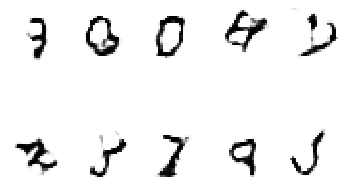

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.546875, 0.5390625, 0.37109375
1 / 100: 0.484375, 0.4296875, 0.37890625
2 / 100: 0.46875, 0.4609375, 0.3984375
3 / 100: 0.5703125, 0.46875, 0.36328125
4 / 100: 0.53125, 0.515625, 0.421875
5 / 100: 0.5078125, 0.5078125, 0.4296875
6 / 100: 0.5390625, 0.4296875, 0.3984375
7 / 100: 0.5078125, 0.453125, 0.34765625
8 / 100: 0.4765625, 0.4609375, 0.40234375
9 / 100: 0.5625, 0.5625, 0.34375
10 / 100: 0.515625, 0.46875, 0.3828125
11 / 100: 0.5, 0.515625, 0.37890625
12 / 100: 0.390625, 0.5078125, 0.3515625
13 / 100: 0.453125, 0.5078125, 0.4375
14 / 100: 0.6171875, 0.5078125, 0.37109375
15 / 100: 0.53125, 0.4296875, 0.48046875
16 / 100: 0.4375, 0.4765625, 0.37890625
17 / 100: 0.4921875, 0.4765625, 0.37890625
18 / 100: 0.4921875, 0.46875, 0.375
19 / 100: 0.46875, 0.421875, 0.37109375
20 / 100: 0.453125, 0.46875, 0.390625
21 / 100: 0.53125, 0.453125, 0.41796875
22 / 100: 0.46875, 0.5390625, 0.33203125
23 / 100: 0.5

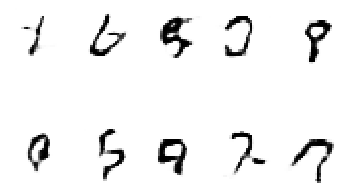

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.4609375, 0.546875, 0.46484375
1 / 100: 0.53125, 0.515625, 0.43359375
2 / 100: 0.5234375, 0.5078125, 0.36328125
3 / 100: 0.5078125, 0.53125, 0.4609375
4 / 100: 0.59375, 0.4921875, 0.42578125
5 / 100: 0.515625, 0.546875, 0.40625
6 / 100: 0.515625, 0.453125, 0.40234375
7 / 100: 0.515625, 0.4453125, 0.453125
8 / 100: 0.46875, 0.4609375, 0.45703125
9 / 100: 0.5234375, 0.4921875, 0.421875
10 / 100: 0.46875, 0.484375, 0.42578125
11 / 100: 0.5078125, 0.515625, 0.3671875
12 / 100: 0.5, 0.4296875, 0.42578125
13 / 100: 0.484375, 0.34375, 0.43359375
14 / 100: 0.4765625, 0.46875, 0.40234375
15 / 100: 0.5078125, 0.4453125, 0.3984375
16 / 100: 0.5, 0.46875, 0.41015625
17 / 100: 0.515625, 0.5546875, 0.4140625
18 / 100: 0.59375, 0.5703125, 0.34375
19 / 100: 0.3984375, 0.4453125, 0.421875
20 / 100: 0.46875, 0.4140625, 0.4140625
21 / 100: 0.5, 0.4609375, 0.375
22 / 100: 0.5859375, 0.5234375, 0.36328125
23 / 100: 0.5, 0.

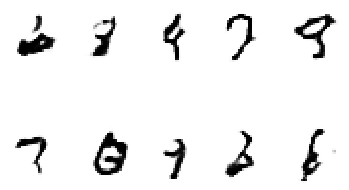

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.59375, 0.5390625, 0.375
1 / 100: 0.59375, 0.5546875, 0.41796875
2 / 100: 0.484375, 0.5390625, 0.4140625
3 / 100: 0.4765625, 0.4921875, 0.4140625
4 / 100: 0.40625, 0.453125, 0.45703125
5 / 100: 0.5625, 0.4296875, 0.41015625
6 / 100: 0.515625, 0.453125, 0.42578125
7 / 100: 0.4609375, 0.5, 0.3984375
8 / 100: 0.515625, 0.4765625, 0.3828125
9 / 100: 0.5546875, 0.5390625, 0.41015625
10 / 100: 0.53125, 0.421875, 0.44140625
11 / 100: 0.4765625, 0.484375, 0.44140625
12 / 100: 0.5078125, 0.5625, 0.35546875
13 / 100: 0.5078125, 0.421875, 0.421875
14 / 100: 0.4921875, 0.4921875, 0.3984375
15 / 100: 0.46875, 0.4609375, 0.46875
16 / 100: 0.4921875, 0.515625, 0.4296875
17 / 100: 0.4765625, 0.4921875, 0.390625
18 / 100: 0.4609375, 0.53125, 0.46875
19 / 100: 0.53125, 0.53125, 0.390625
20 / 100: 0.46875, 0.4921875, 0.38671875
21 / 100: 0.5859375, 0.4609375, 0.359375
22 / 100: 0.4765625, 0.53125, 0.3671875
23 / 100: 0.4

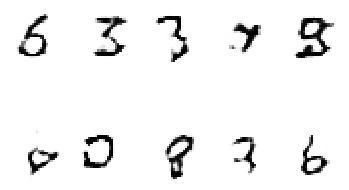

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5625, 0.6015625, 0.3828125
1 / 100: 0.484375, 0.5234375, 0.36328125
2 / 100: 0.4296875, 0.4609375, 0.41796875
3 / 100: 0.53125, 0.5, 0.43359375
4 / 100: 0.59375, 0.515625, 0.51171875
5 / 100: 0.4296875, 0.46875, 0.375
6 / 100: 0.515625, 0.4921875, 0.3828125
7 / 100: 0.53125, 0.5390625, 0.4453125
8 / 100: 0.546875, 0.4375, 0.3984375
9 / 100: 0.5390625, 0.515625, 0.48046875
10 / 100: 0.46875, 0.4921875, 0.40625
11 / 100: 0.53125, 0.5234375, 0.41796875
12 / 100: 0.5234375, 0.5234375, 0.4453125
13 / 100: 0.53125, 0.4375, 0.4765625
14 / 100: 0.453125, 0.4375, 0.35546875
15 / 100: 0.515625, 0.4921875, 0.4140625
16 / 100: 0.4921875, 0.5546875, 0.44140625
17 / 100: 0.6015625, 0.5, 0.421875
18 / 100: 0.5078125, 0.515625, 0.41796875
19 / 100: 0.484375, 0.5, 0.37890625
20 / 100: 0.3984375, 0.515625, 0.4375
21 / 100: 0.4609375, 0.4765625, 0.4765625
22 / 100: 0.4765625, 0.5390625, 0.38671875
23 / 100: 0.46875, 0.4

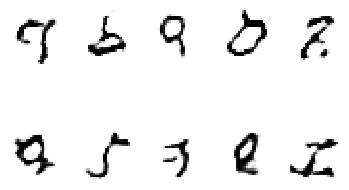

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.4375, 0.4765625, 0.36328125
1 / 100: 0.5078125, 0.5234375, 0.42578125
2 / 100: 0.5234375, 0.53125, 0.39453125
3 / 100: 0.5234375, 0.5, 0.35546875
4 / 100: 0.609375, 0.5625, 0.39453125
5 / 100: 0.4296875, 0.4375, 0.4375
6 / 100: 0.5234375, 0.4453125, 0.42578125
7 / 100: 0.4453125, 0.4375, 0.38671875
8 / 100: 0.5703125, 0.5, 0.390625
9 / 100: 0.5234375, 0.484375, 0.43359375
10 / 100: 0.5546875, 0.4921875, 0.4375
11 / 100: 0.4609375, 0.53125, 0.41015625
12 / 100: 0.4765625, 0.5234375, 0.38671875
13 / 100: 0.5703125, 0.5, 0.36328125
14 / 100: 0.5546875, 0.421875, 0.390625
15 / 100: 0.4609375, 0.5, 0.3359375
16 / 100: 0.5078125, 0.53125, 0.35546875
17 / 100: 0.5078125, 0.3984375, 0.42578125
18 / 100: 0.578125, 0.390625, 0.3984375
19 / 100: 0.53125, 0.5, 0.3984375
20 / 100: 0.453125, 0.4765625, 0.3671875
21 / 100: 0.5078125, 0.4609375, 0.39453125
22 / 100: 0.4453125, 0.546875, 0.3515625
23 / 100: 0.53125, 0

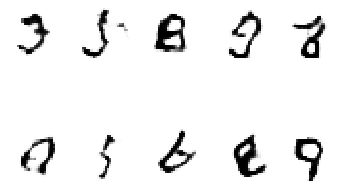

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.515625, 0.53125, 0.421875
1 / 100: 0.4609375, 0.5, 0.4140625
2 / 100: 0.4921875, 0.4921875, 0.375
3 / 100: 0.5078125, 0.4375, 0.38671875
4 / 100: 0.4609375, 0.5703125, 0.4140625
5 / 100: 0.5390625, 0.578125, 0.3671875
6 / 100: 0.46875, 0.484375, 0.40234375
7 / 100: 0.4296875, 0.5390625, 0.41015625
8 / 100: 0.484375, 0.5859375, 0.40234375
9 / 100: 0.484375, 0.375, 0.48828125
10 / 100: 0.484375, 0.5078125, 0.44140625
11 / 100: 0.5703125, 0.5, 0.36328125
12 / 100: 0.4765625, 0.4765625, 0.4296875
13 / 100: 0.546875, 0.5, 0.41015625
14 / 100: 0.484375, 0.5, 0.40625
15 / 100: 0.5703125, 0.5078125, 0.46875
16 / 100: 0.5234375, 0.515625, 0.44140625
17 / 100: 0.515625, 0.4921875, 0.421875
18 / 100: 0.5, 0.4453125, 0.38671875
19 / 100: 0.4296875, 0.453125, 0.4140625
20 / 100: 0.5234375, 0.5703125, 0.4296875
21 / 100: 0.578125, 0.484375, 0.40625
22 / 100: 0.453125, 0.5390625, 0.44140625
23 / 100: 0.515625, 0.562

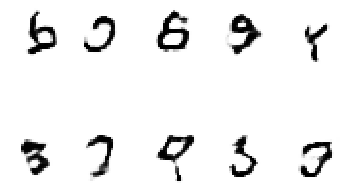

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5078125, 0.4140625, 0.4140625
1 / 100: 0.453125, 0.5, 0.33984375
2 / 100: 0.4921875, 0.46875, 0.375
3 / 100: 0.5234375, 0.4921875, 0.40625
4 / 100: 0.5078125, 0.5078125, 0.35546875
5 / 100: 0.515625, 0.5546875, 0.4140625
6 / 100: 0.453125, 0.5546875, 0.3984375
7 / 100: 0.4765625, 0.4921875, 0.375
8 / 100: 0.5234375, 0.5625, 0.390625
9 / 100: 0.5546875, 0.4921875, 0.3828125
10 / 100: 0.4609375, 0.5546875, 0.37109375
11 / 100: 0.5390625, 0.5625, 0.37890625
12 / 100: 0.453125, 0.5, 0.390625
13 / 100: 0.4765625, 0.53125, 0.4375
14 / 100: 0.5546875, 0.5078125, 0.41015625
15 / 100: 0.4765625, 0.4453125, 0.44921875
16 / 100: 0.5, 0.453125, 0.3828125
17 / 100: 0.5703125, 0.5, 0.38671875
18 / 100: 0.5390625, 0.453125, 0.421875
19 / 100: 0.4921875, 0.4296875, 0.40234375
20 / 100: 0.46875, 0.46875, 0.3984375
21 / 100: 0.4765625, 0.4921875, 0.41015625
22 / 100: 0.5625, 0.421875, 0.4296875
23 / 100: 0.4765625, 0.5

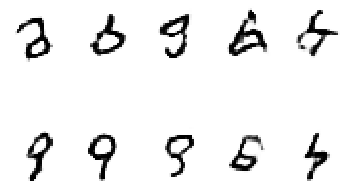

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5390625, 0.4453125, 0.4453125
1 / 100: 0.5234375, 0.4609375, 0.3828125
2 / 100: 0.5390625, 0.546875, 0.375
3 / 100: 0.5078125, 0.5, 0.37109375
4 / 100: 0.5, 0.5234375, 0.44921875
5 / 100: 0.5234375, 0.453125, 0.46484375
6 / 100: 0.5234375, 0.5390625, 0.421875
7 / 100: 0.46875, 0.484375, 0.390625
8 / 100: 0.5078125, 0.5390625, 0.390625
9 / 100: 0.5234375, 0.5234375, 0.3515625
10 / 100: 0.4296875, 0.515625, 0.31640625
11 / 100: 0.5703125, 0.46875, 0.3515625
12 / 100: 0.46875, 0.4375, 0.39453125
13 / 100: 0.5234375, 0.4609375, 0.390625
14 / 100: 0.5, 0.53125, 0.390625
15 / 100: 0.5625, 0.515625, 0.3671875
16 / 100: 0.421875, 0.4375, 0.4609375
17 / 100: 0.5078125, 0.53125, 0.47265625
18 / 100: 0.5390625, 0.53125, 0.41796875
19 / 100: 0.5, 0.453125, 0.43359375
20 / 100: 0.515625, 0.453125, 0.4296875
21 / 100: 0.4609375, 0.375, 0.39453125
22 / 100: 0.5546875, 0.5234375, 0.4375
23 / 100: 0.5, 0.5546875, 0.44

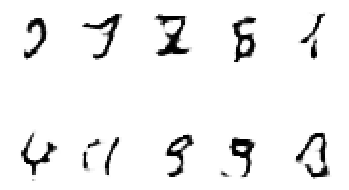

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5390625, 0.3984375, 0.4375
1 / 100: 0.5390625, 0.4609375, 0.40234375
2 / 100: 0.4921875, 0.46875, 0.39453125
3 / 100: 0.4453125, 0.4765625, 0.421875
4 / 100: 0.53125, 0.546875, 0.41015625
5 / 100: 0.4375, 0.4765625, 0.359375
6 / 100: 0.4453125, 0.5234375, 0.3671875
7 / 100: 0.4921875, 0.5625, 0.36328125
8 / 100: 0.4921875, 0.6015625, 0.41015625
9 / 100: 0.5, 0.6015625, 0.3984375
10 / 100: 0.5234375, 0.5078125, 0.3671875
11 / 100: 0.5078125, 0.3984375, 0.4296875
12 / 100: 0.5, 0.5546875, 0.45703125
13 / 100: 0.5078125, 0.4296875, 0.3984375
14 / 100: 0.484375, 0.5546875, 0.421875
15 / 100: 0.53125, 0.484375, 0.45703125
16 / 100: 0.5546875, 0.5546875, 0.3671875
17 / 100: 0.546875, 0.484375, 0.40234375
18 / 100: 0.5625, 0.46875, 0.390625
19 / 100: 0.453125, 0.5546875, 0.40234375
20 / 100: 0.453125, 0.5703125, 0.43359375
21 / 100: 0.4453125, 0.4609375, 0.41796875
22 / 100: 0.5234375, 0.546875, 0.4296875
23

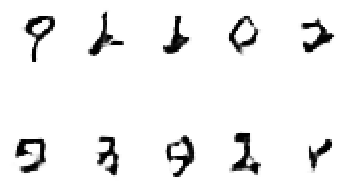

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5546875, 0.5234375, 0.421875
1 / 100: 0.484375, 0.4765625, 0.45703125
2 / 100: 0.5078125, 0.5, 0.46484375
3 / 100: 0.4921875, 0.5, 0.39453125
4 / 100: 0.484375, 0.609375, 0.3828125
5 / 100: 0.546875, 0.421875, 0.43359375
6 / 100: 0.453125, 0.4375, 0.4375
7 / 100: 0.5234375, 0.5, 0.43359375
8 / 100: 0.515625, 0.46875, 0.421875
9 / 100: 0.5, 0.4375, 0.37890625
10 / 100: 0.484375, 0.4921875, 0.4296875
11 / 100: 0.5859375, 0.484375, 0.39453125
12 / 100: 0.484375, 0.484375, 0.3671875
13 / 100: 0.5, 0.4921875, 0.4296875
14 / 100: 0.4609375, 0.484375, 0.43359375
15 / 100: 0.5, 0.5703125, 0.43359375
16 / 100: 0.5234375, 0.59375, 0.35546875
17 / 100: 0.6171875, 0.484375, 0.34375
18 / 100: 0.4375, 0.5, 0.4375
19 / 100: 0.4609375, 0.46875, 0.43359375
20 / 100: 0.5390625, 0.484375, 0.41015625
21 / 100: 0.484375, 0.3828125, 0.3828125
22 / 100: 0.484375, 0.453125, 0.375
23 / 100: 0.5234375, 0.5625, 0.3515625
24 / 1

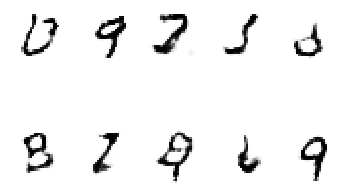

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.5078125, 0.484375, 0.390625
1 / 100: 0.46875, 0.625, 0.390625
2 / 100: 0.6015625, 0.4609375, 0.3671875
3 / 100: 0.5546875, 0.4609375, 0.4375
4 / 100: 0.4453125, 0.4140625, 0.40234375
5 / 100: 0.5234375, 0.484375, 0.4453125
6 / 100: 0.6328125, 0.5234375, 0.4140625
7 / 100: 0.5078125, 0.484375, 0.33984375
8 / 100: 0.53125, 0.515625, 0.40234375
9 / 100: 0.4296875, 0.5625, 0.41796875
10 / 100: 0.46875, 0.46875, 0.3515625
11 / 100: 0.515625, 0.4375, 0.38671875
12 / 100: 0.4765625, 0.5078125, 0.4296875
13 / 100: 0.453125, 0.4296875, 0.38671875
14 / 100: 0.4453125, 0.53125, 0.34765625
15 / 100: 0.5390625, 0.4765625, 0.36328125
16 / 100: 0.4609375, 0.4296875, 0.3671875
17 / 100: 0.46875, 0.46875, 0.38671875
18 / 100: 0.515625, 0.5078125, 0.328125
19 / 100: 0.5, 0.5546875, 0.3828125
20 / 100: 0.5859375, 0.5, 0.36328125
21 / 100: 0.5390625, 0.546875, 0.4140625
22 / 100: 0.5078125, 0.4375, 0.4296875
23 / 100: 0.

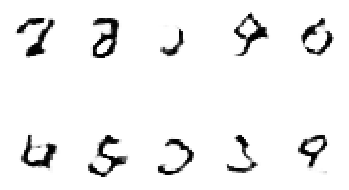

In [11]:
EVALUATION_ROUNDS = 50
BATCHES = 100
BATCH_SIZE = 256

# Lets get fresh copies of everything.
discriminator = create_discriminator(INPUT_SHAPE)
generator = create_generator(NOISE_DIM, DENSE_LAYER_SIZE)
gan = create_gan(generator, discriminator)

for i in range(EVALUATION_ROUNDS):
    train_gan(gan, generator, discriminator, NOISE_DIM, BATCHES, BATCH_SIZE)
    print(f'After {(i+1)*BATCHES*BATCH_SIZE} samples:')
    
    # To evaluate, we'll look at 10 randomly generated samples.
    fake_images, _ = generate_fake_batch(generator, NOISE_DIM, 10)

    for i in range(10):
        ax = plt.subplot(2, 5, i+1)
        ax.axis('off')
        plt.imshow(fake_images[i, :, :, 0], cmap='Greys')

    plt.show()

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 25600 samples:


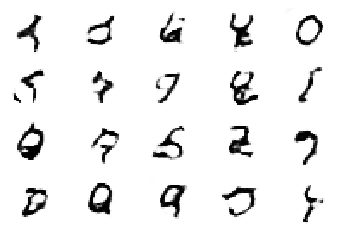


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 51200 samples:


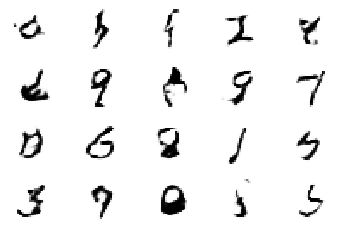


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 76800 samples:


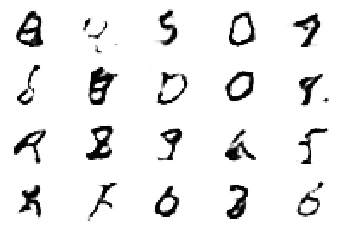


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 102400 samples:


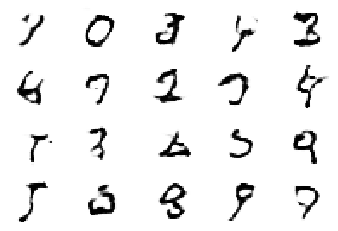


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 128000 samples:


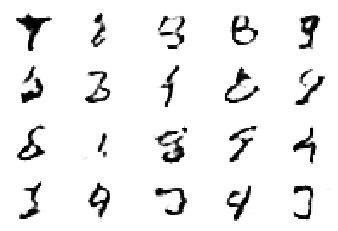


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 153600 samples:


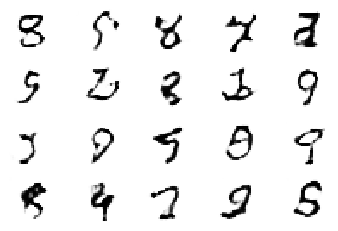


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 179200 samples:


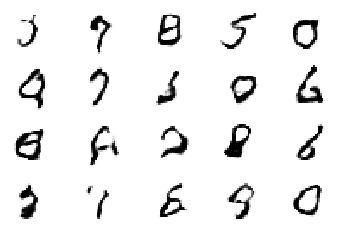


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 204800 samples:


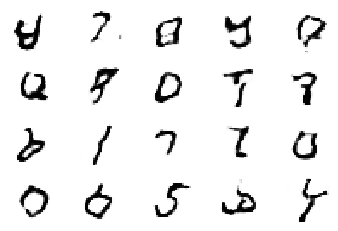


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 230400 samples:


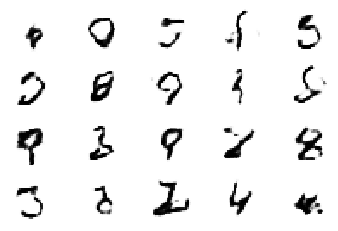


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 256000 samples:


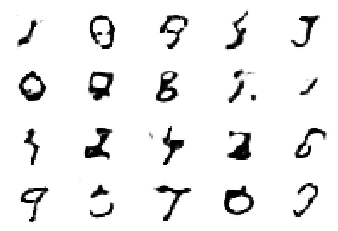


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 281600 samples:


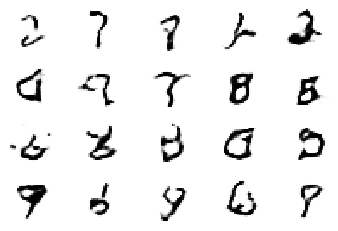


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 307200 samples:


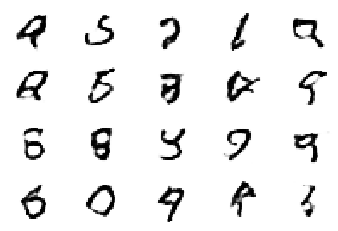


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 332800 samples:


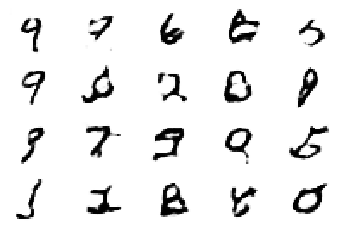


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 358400 samples:


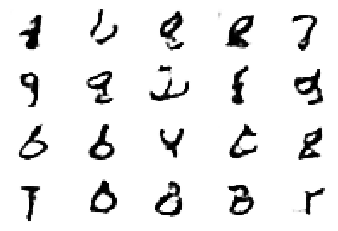


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 384000 samples:


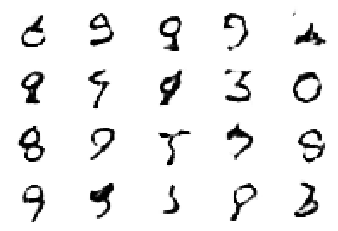


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 409600 samples:


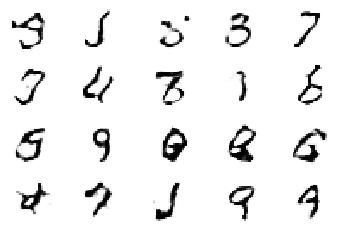


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 435200 samples:


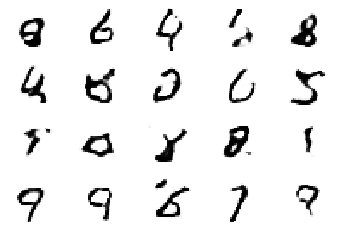


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 460800 samples:


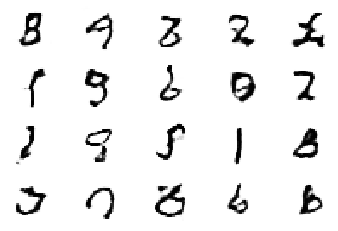


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 486400 samples:


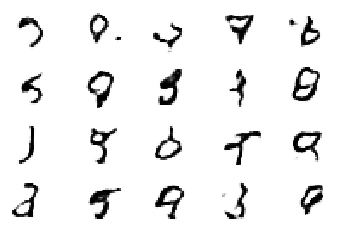


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 512000 samples:


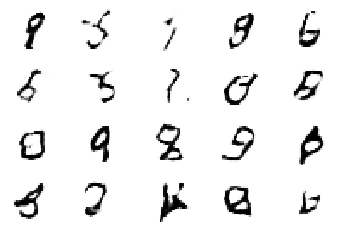


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 537600 samples:


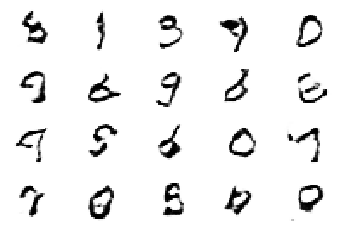


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 563200 samples:


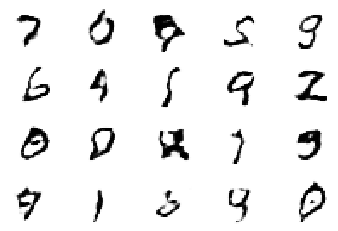


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 588800 samples:


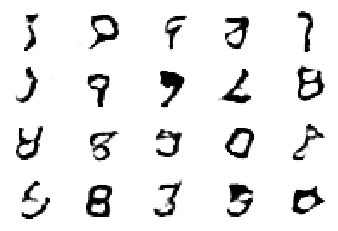


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 614400 samples:


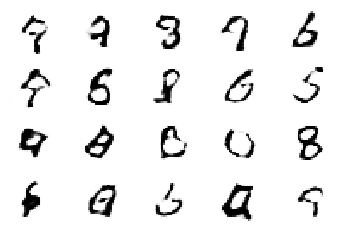


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 640000 samples:


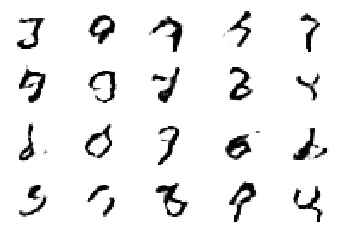


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 665600 samples:


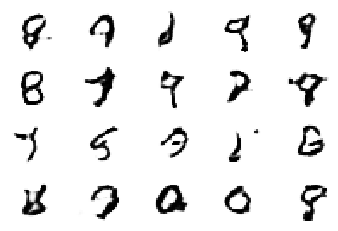


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 691200 samples:


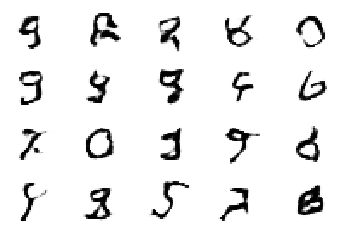


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 716800 samples:


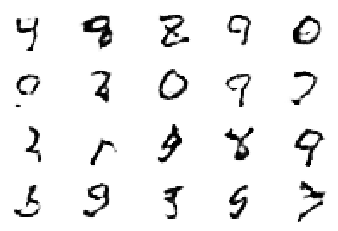


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 742400 samples:


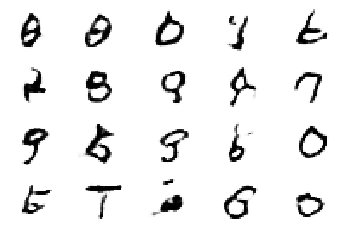


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 768000 samples:


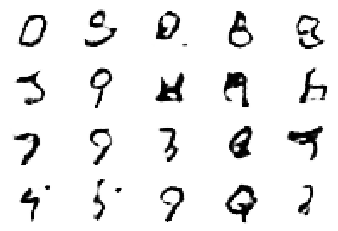


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 793600 samples:


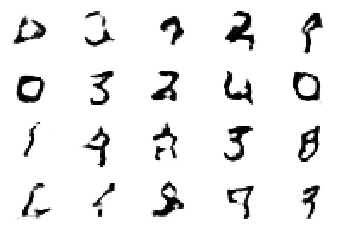


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 819200 samples:


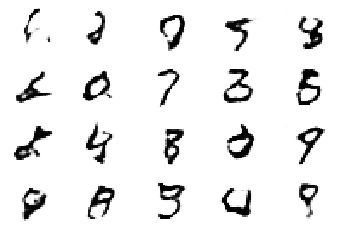


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 844800 samples:


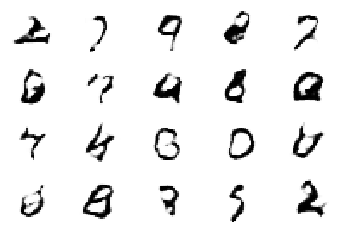


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 870400 samples:


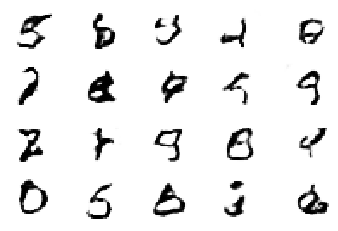


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 896000 samples:


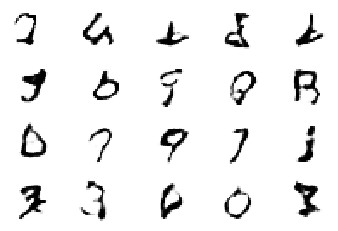


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 921600 samples:


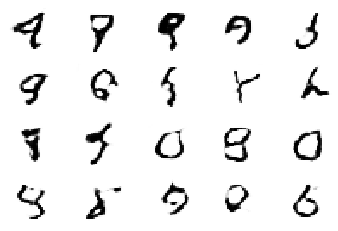


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 947200 samples:


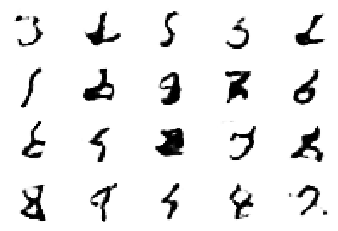


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 972800 samples:


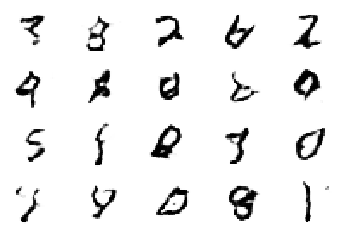


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 998400 samples:


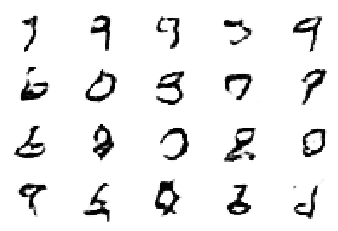


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1024000 samples:


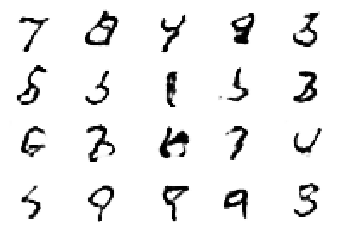


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1049600 samples:


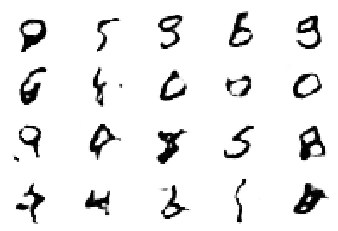


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1075200 samples:


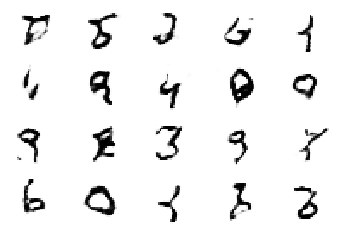


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1100800 samples:


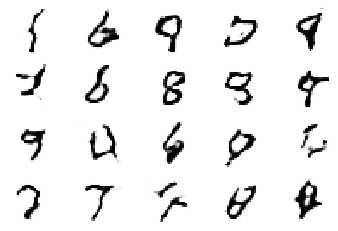


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1126400 samples:


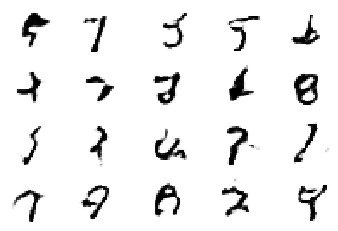


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1152000 samples:


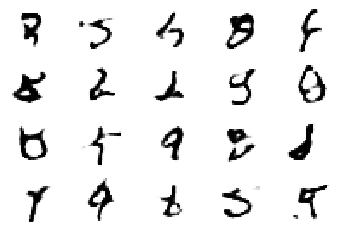


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1177600 samples:


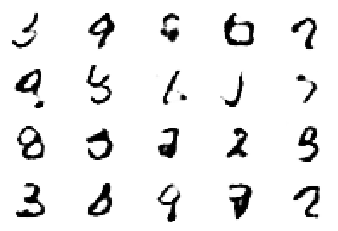


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1203200 samples:


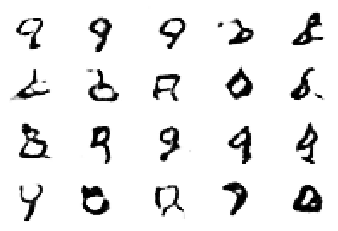


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1228800 samples:


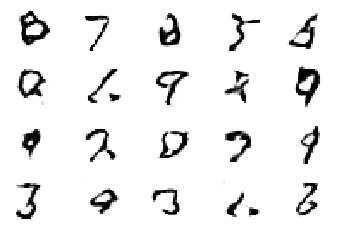


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1254400 samples:


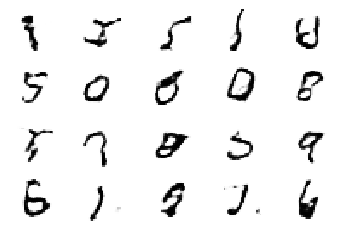


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1280000 samples:


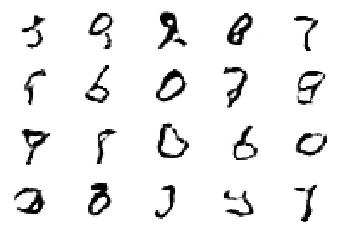

In [16]:
for i in range(EVALUATION_ROUNDS):
    train_gan(gan, generator, discriminator, NOISE_DIM, BATCHES, BATCH_SIZE, verbose=False)
    print(f'After {(i+1)*BATCHES*BATCH_SIZE} samples:')
    
    # To evaluate, we'll look at 20 randomly generated samples.
    fake_images, _ = generate_fake_batch(generator, NOISE_DIM, 20)

    for i in range(20):
        ax = plt.subplot(4, 5, i+1)
        ax.axis('off')
        plt.imshow(fake_images[i, :, :, 0], cmap='Greys')

    plt.show()
    print()

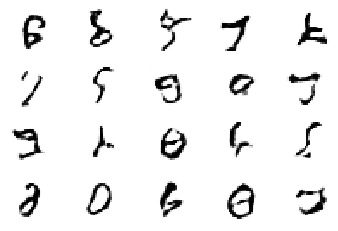

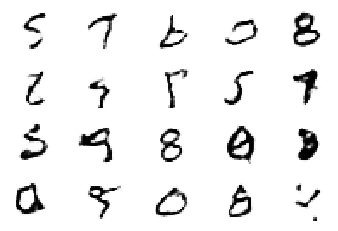

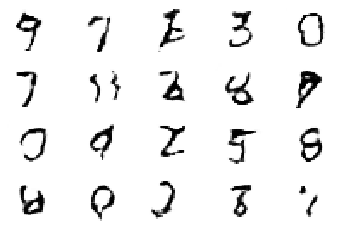

In [ ]:
# And, after training on ~2.5M samples, lets look at a larger selection
# of generated digits.
for j in range(4):
    fake_images, _ = generate_fake_batch(generator, NOISE_DIM, 20)

    for i in range(20):
        ax = plt.subplot(4, 5, i+1)
        ax.axis('off')
        plt.imshow(fake_images[i, :, :, 0], cmap='Greys')
    
    plt.show()